<a href="https://www.kaggle.com/code/dataranch/carbon-pricing-feature-importance?scriptVersionId=110340996" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Carbon Pricing | Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

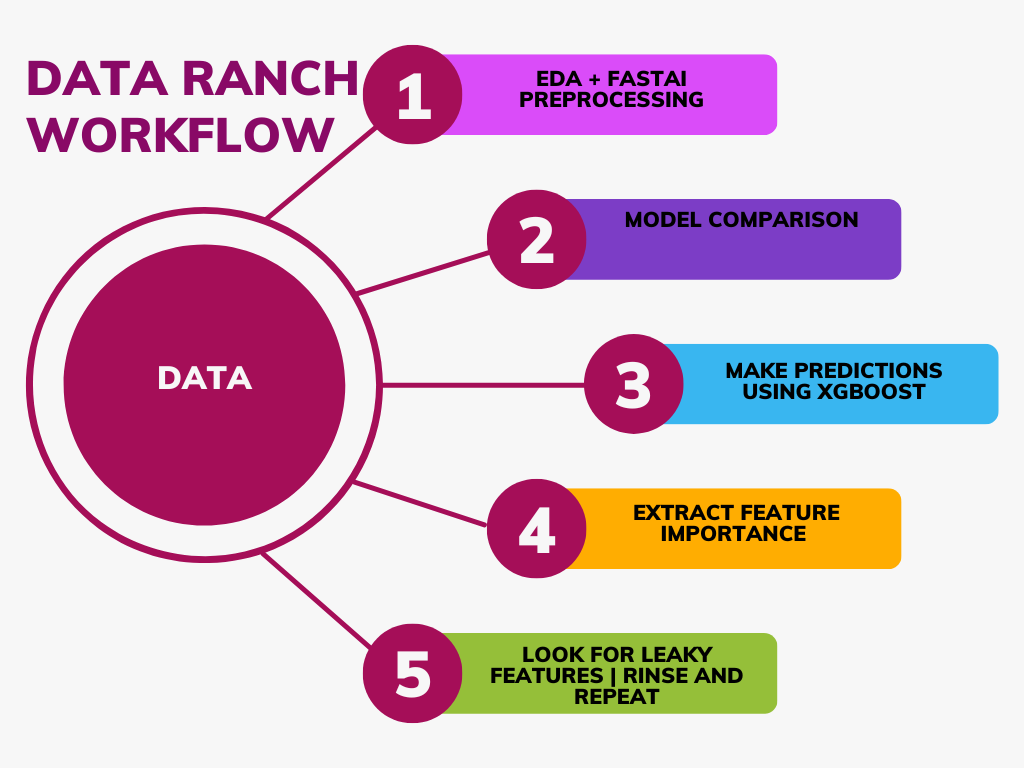

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 505.2 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'world-carbon-pricing'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 4000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = False
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
input_path = '../input/world-carbon-pricing/national'
dfs = []
for csv in os.listdir(input_path):
    dfs.append(pd.read_csv(f'{input_path}/{csv}'))

df = pd.concat(dfs)

param_dir: /kaggle/working/world-carbon-pricing


In [12]:
df

,jurisdiction,year,ipcc_code,Product,tax,ets,tax_id,tax_rate_excl_ex_clcu,tax_ex_rate,tax_rate_incl_ex_clcu,tax_curr_code,ets_id,ets_price,ets_curr_code,ets_2_id,ets_2_price,ets_2_curr_code
0,Sudan,1989,0,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sudan,1989,1,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sudan,1989,1A,Coal,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sudan,1989,1A,Natural gas,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sudan,1989,1A,Oil,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10127,Luxembourg,2022,4E,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10128,Luxembourg,2022,5,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10129,Luxembourg,2022,5A,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10130,Luxembourg,2022,5A1,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
if SHUFFLE_DATA:
    df = df.sample(frac=1).reset_index(drop=True)
df = df[0:SAMPLE_COUNT]

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

,jurisdiction,year,ipcc_code,Product,tax,ets,tax_id,tax_rate_excl_ex_clcu,tax_ex_rate,tax_rate_incl_ex_clcu,tax_curr_code,ets_id,ets_price,ets_curr_code,ets_2_id,ets_2_price,ets_2_curr_code
0,St. Kitts and Nevis,2004,1B2A32,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Liberia,1992,2B6,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Niger,2020,4C1,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,New Zealand,2017,3B5B,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dominica,2013,3B2,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Cyprus,2003,3C7,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3996,Brazil,1999,3B6B3,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3997,Brazil,2017,4D2,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3998,St. Lucia,2017,1A1C,Oil,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df

,jurisdiction,year,ipcc_code,Product,tax,ets,tax_id,tax_rate_excl_ex_clcu,tax_ex_rate,tax_rate_incl_ex_clcu,tax_curr_code,ets_id,ets_price,ets_curr_code,ets_2_id,ets_2_price,ets_2_curr_code
0,St. Kitts and Nevis,2004,1B2A32,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Liberia,1992,2B6,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Niger,2020,4C1,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,New Zealand,2017,3B5B,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dominica,2013,3B2,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Cyprus,2003,3C7,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3996,Brazil,1999,3B6B3,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3997,Brazil,2017,4D2,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3998,St. Lucia,2017,1A1C,Oil,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.isna().sum()

jurisdiction                0
year                        0
ipcc_code                   0
Product                  2240
tax                         0
ets                         0
tax_id                   3983
tax_rate_excl_ex_clcu    3984
tax_ex_rate              3983
tax_rate_incl_ex_clcu    3984
tax_curr_code            3983
ets_id                   3921
ets_price                3921
ets_curr_code            3921
ets_2_id                 4000
ets_2_price              4000
ets_2_curr_code          4000
dtype: int64

In [17]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

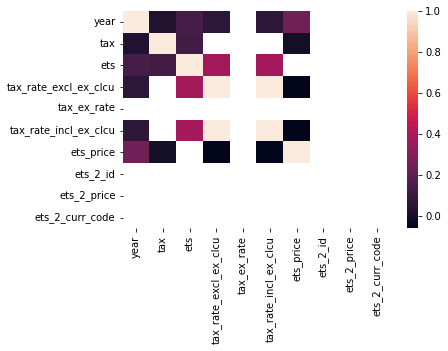

In [18]:
sns.heatmap(df.corr())

In [19]:
df.head().style.background_gradient(cmap = "inferno")

,jurisdiction,year,ipcc_code,Product,tax,ets,tax_id,tax_rate_excl_ex_clcu,tax_ex_rate,tax_rate_incl_ex_clcu,tax_curr_code,ets_id,ets_price,ets_curr_code,ets_2_id,ets_2_price,ets_2_curr_code
0,St. Kitts and Nevis,2004,1B2A32,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,Liberia,1992,2B6,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,Niger,2020,4C1,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,New Zealand,2017,3B5B,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,Dominica,2013,3B2,nan,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [20]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
year,4000.00,2005.34,9.78,1989.00,1997.00,2005.00,2014.00,2022.00
tax,4000.00,0.00,0.07,0.00,0.00,0.00,0.00,1.00
ets,4000.00,0.02,0.14,0.00,0.00,0.00,0.00,1.00
tax_rate_excl_ex_clcu,16.00,52.02,109.35,0.19,9.75,13.76,25.07,440.00
tax_ex_rate,17.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
tax_rate_incl_ex_clcu,16.00,52.02,109.35,0.19,9.75,13.76,25.07,440.00
ets_price,79.00,22.84,48.76,0.72,6.52,13.15,24.76,431.00
ets_2_id,0.00,nan,nan,nan,nan,nan,nan,nan
ets_2_price,0.00,nan,nan,nan,nan,nan,nan,nan
ets_2_curr_code,0.00,nan,nan,nan,nan,nan,nan,nan


In [21]:
df.columns

Index(['jurisdiction', 'year', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id',
       'tax_rate_excl_ex_clcu', 'tax_ex_rate', 'tax_rate_incl_ex_clcu',
       'tax_curr_code', 'ets_id', 'ets_price', 'ets_curr_code', 'ets_2_id',
       'ets_2_price', 'ets_2_curr_code'],
      dtype='object')

Target Variable: ets_2_curr_code
CATS=====================
['year', 'Product', 'tax', 'ets', 'tax_id', 'tax_rate_excl_ex_clcu', 'tax_ex_rate', 'tax_rate_incl_ex_clcu', 'tax_curr_code', 'ets_id', 'ets_price', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['jurisdiction', 'ipcc_code']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['jurisdiction', 'ipcc_code']
Categorical variables that made the cut : ['year', 'Product', 'tax', 'ets', 'tax_id', 'tax_rate_excl_ex_clcu', 'tax_ex_rate', 'tax_rate_incl_ex_clcu', 'tax_curr_code', 'ets_id', 'ets_price', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code', 'jurisdiction_na', 'ipcc_code_na']
Tabular Object size: 4000


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.020885467529296875}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.037598609924316406}


  7%|▋         | 3/42 [00:00<00:01, 26.02it/s]

{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.056331634521484375}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.06549477577209473}


 14%|█▍        | 6/42 [00:00<00:01, 19.75it/s]

{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04869508743286133}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05974578857421875}
{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.5705852508544922}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02541184425354004}


 21%|██▏       | 9/42 [00:01<00:04,  6.81it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.18403267860412598}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01503896713256836}


 31%|███       | 13/42 [00:03<00:08,  3.35it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 0.07131699750001835, 'Time taken': 1.8997595310211182}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.08647918701171875}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07583308219909668}


 36%|███▌      | 15/42 [00:03<00:06,  4.19it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 6.13392294556433e-12, 'Time taken': 0.13167953491210938}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.11503124237060547}


 45%|████▌     | 19/42 [00:04<00:04,  5.01it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 0.9999999999998914, 'Time taken': 0.6955199241638184}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.027657747268676758}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09525299072265625}


 55%|█████▍    | 23/42 [00:05<00:03,  5.44it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.6081140041351318}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.051041364669799805}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.048272132873535156}


 60%|█████▉    | 25/42 [00:05<00:02,  6.75it/s]

{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05437827110290527}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 6.8173330486827555e-06, 'Time taken': 0.0797734260559082}
{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 0.056527914565357266, 'Time taken': 0.8265299797058105}


 74%|███████▍  | 31/42 [00:06<00:01,  6.55it/s]

{'Model': 'NuSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 2.1316282072803006e-14, 'Time taken': 0.21473264694213867}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02039933204650879}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 0.06897256813311153, 'Time taken': 0.031093835830688477}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.026038408279418945}


 76%|███████▌  | 32/42 [06:41<09:25, 56.54s/it]

{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 5.684341886080802e-14, 'Time taken': 394.99086332321167}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04358673095703125}


 88%|████████▊ | 37/42 [06:41<02:04, 24.82s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2490098476409912}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.022823810577392578}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05996537208557129}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 0.00592275160688351, 'Time taken': 0.09212183952331543}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.027625560760498047}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02783966064453125}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02526116371154785}


100%|██████████| 42/42 [06:42<00:00,  9.58s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023047375160051287, 'RMSE': 5.9604645e-08, 'Time taken': 0.4939732551574707}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09838247299194336}
Project: world-carbon-pricing
world-carbon-pricing
Target: ets_2_curr_code
ets_2_curr_code
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
Lars                                         1.00       1.00  0.00        0.03
TweedieRegressor                             1.00       1.00  0.00        0.03
TransformedTargetRegressor                   1.00       1.00  0.00        0.03
SVR                                          1.00       1.00  0.00        0.03
RidgeCV                                      1.00       1.0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Could not fit model


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 280, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: ets_2_price
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_rate_excl_ex_clcu', 'tax_ex_rate', 'tax_rate_incl_ex_clcu', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'ets_price']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_rate_excl_ex_clcu', 'tax_ex_rate', 'tax_rate_incl_ex_clcu', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 309, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Tabular Object size: 321


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013491630554199219}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.028676509857177734}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011817216873168945}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011023521423339844}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010175704956054688}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013283014297485352}


 24%|██▍       | 10/42 [00:00<00:01, 24.70it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.18960165977478027}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013055801391601562}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09868001937866211}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011610269546508789}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 0.17678233914231037, 'Time taken': 0.0448460578918457}


 40%|████      | 17/42 [00:00<00:01, 23.57it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.12656450271606445}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0541844367980957}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 2.2407922193220642e-10, 'Time taken': 0.031563758850097656}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.016460657119750977}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 0.999999999999975, 'Time taken': 0.026367664337158203}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.026918888092041016}
LarsCV model failed to execute
x and y arrays must have at least 2 entries


 48%|████▊     | 20/42 [00:01<00:01, 17.48it/s]

{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.046276092529296875}
{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.19985294342041016}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01771259307861328}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015393972396850586}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013484477996826172}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 7.300527137788663e-05, 'Time taken': 0.014264106750488281}


 71%|███████▏  | 30/42 [00:01<00:00, 22.13it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 0.11745901716713048, 'Time taken': 0.21573567390441895}
{'Model': 'NuSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 5.329070518200751e-15, 'Time taken': 0.027877092361450195}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.025593042373657227}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 0.07847660990025043, 'Time taken': 0.02812647819519043}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014153718948364258}


 79%|███████▊  | 33/42 [00:02<00:00, 11.62it/s]

{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 1.474376176702208e-13, 'Time taken': 0.5908160209655762}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02465057373046875}


 83%|████████▎ | 35/42 [00:02<00:00, 11.15it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.19243311882019043}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011191129684448242}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013709068298339844}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 0.006378989102484976, 'Time taken': 0.013068199157714844}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013973474502563477}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014682531356811523}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014362573623657227}


100%|██████████| 42/42 [00:02<00:00, 15.36it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.34042553191489366, 'RMSE': 5.9604645e-08, 'Time taken': 0.37247753143310547}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03319406509399414}
Project: world-carbon-pricing
world-carbon-pricing
Target: ets_2_price
ets_2_price
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
Lars                                         1.00       1.00  0.00        0.03
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                      1.00       1.00  0.00 

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,10.976264,0.036066,0.189910,00:00
1,10.843910,0.235288,0.485065,00:00


Better model found at epoch 0 with _rmse value: 0.18991009891033173.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: ets_2_id
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
17
Looping through continuous variables to find breakpoint


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 309, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 311


 14%|█▍        | 6/42 [00:00<00:00, 56.01it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.018179655075073242}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03092503547668457}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013637781143188477}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012833356857299805}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01425027847290039}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.016809463500976562}
{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.19942212104797363}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011661767959594727}
{'Model': 'ExtraTr

 38%|███▊      | 16/42 [00:00<00:01, 22.39it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09291434288024902}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05814409255981445}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.648001323998429e-11, 'Time taken': 0.0302886962890625}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012327432632446289}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.0000000000000175, 'Time taken': 0.018309354782104492}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04479217529296875}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0336306095123291}


 48%|████▊     | 20/42 [00:01<00:01, 17.82it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.1879262924194336}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013316154479980469}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01200723648071289}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011032581329345703}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 2.8317645938950047e-05, 'Time taken': 0.011379241943359375}


 74%|███████▍  | 31/42 [00:01<00:00, 23.92it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.10982909462771942, 'Time taken': 0.20463323593139648}
{'Model': 'NuSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 4.440892098500626e-15, 'Time taken': 0.02614760398864746}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.023308277130126953}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.06184989963660931, 'Time taken': 0.024989843368530273}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01970648765563965}
{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.5987211554602254e-13, 'Time taken': 0.6769490242004395}
{'Model': 'RANSACRegressor',

 83%|████████▎ | 35/42 [00:02<00:00, 10.55it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.18602871894836426}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013137578964233398}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014871358871459961}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.006901127335194613, 'Time taken': 0.012727737426757812}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010848045349121094}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011509180068969727}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011956930160522461}


100%|██████████| 42/42 [00:02<00:00, 15.00it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.9604645e-08, 'Time taken': 0.3789703845977783}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03547835350036621}
Project: world-carbon-pricing
world-carbon-pricing
Target: ets_2_id
ets_2_id
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
Lars                                         1.00       1.00  0.00        0.04
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                      1.00       1.00  0.00        0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,3.867544,5.578703,2.361928,00:00
1,3.919001,0.007494,0.086566,00:00
2,3.596590,0.150137,0.387475,00:00


Better model found at epoch 0 with _rmse value: 2.3619277477264404.
Better model found at epoch 1 with _rmse value: 0.08656588196754456.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: ets_curr_code
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 309, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Tabular Object size: 311


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014341592788696289}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02764105796813965}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012074708938598633}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011207342147827148}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009882926940917969}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012792587280273438}


 24%|██▍       | 10/42 [00:00<00:01, 25.35it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.18163776397705078}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011815309524536133}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09810924530029297}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01116943359375}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.2889638227493839, 'Time taken': 0.03899097442626953}


 43%|████▎     | 18/42 [00:00<00:00, 26.58it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.12129688262939453}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.043976783752441406}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 8.584713599883699e-11, 'Time taken': 0.029649734497070312}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011675119400024414}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.0000000000000078, 'Time taken': 0.033171892166137695}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.021413087844848633}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.028641939163208008

 50%|█████     | 21/42 [00:00<00:01, 19.60it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.21332120895385742}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010881185531616211}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011474609375}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010684013366699219}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.00037872551335519695, 'Time taken': 0.010976314544677734}


 74%|███████▍  | 31/42 [00:01<00:00, 24.98it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.33097589897019203, 'Time taken': 0.1945817470550537}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.024933338165283203}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02236771583557129}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.07196148909513246, 'Time taken': 0.022481918334960938}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02228403091430664}
{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.509903313490213e-13, 'Time taken': 0.5337388515472412}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squar

 81%|████████  | 34/42 [00:02<00:00, 10.95it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.20617413520812988}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01351785659790039}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01442575454711914}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.007060830062059567, 'Time taken': 0.01364898681640625}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012926578521728516}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014131784439086914}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013498783111572266}


100%|██████████| 42/42 [00:02<00:00, 16.21it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.9604645e-08, 'Time taken': 0.37529635429382324}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03499484062194824}
Project: world-carbon-pricing
world-carbon-pricing
Target: ets_curr_code
ets_curr_code
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
Lasso                                        1.00       1.00  0.00        0.03
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                      1.00       1.00  0.

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,35.363178,27.512566,5.245242,00:00
1,25.169519,23.998396,4.898816,00:00
2,20.687601,96.396736,9.818184,00:00


Better model found at epoch 0 with _rmse value: 5.245242118835449.
Better model found at epoch 1 with _rmse value: 4.898815631866455.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: ets_price
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu']
16
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 309, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Tabular Object size: 311


 12%|█▏        | 5/42 [00:00<00:00, 47.58it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -87.37292764976982, 'Adjusted R-Squared': -118.79441303635465, 'RMSE': 51.61576673099958, 'Time taken': 0.035634517669677734}
{'Model': 'BaggingRegressor', 'R-Squared': -42.26717891857928, 'Adjusted R-Squared': -57.651064756296364, 'RMSE': 36.116200170835235, 'Time taken': 0.03065967559814453}
{'Model': 'BayesianRidge', 'R-Squared': -101.651559652359, 'Adjusted R-Squared': -138.14989197319775, 'RMSE': 55.629548838641504, 'Time taken': 0.01393747329711914}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -87.36181048232152, 'Adjusted R-Squared': -118.77934309825807, 'RMSE': 51.61252004004708, 'Time taken': 0.012499809265136719}
{'Model': 'DummyRegressor', 'R-Squared': -0.22497734767894784, 'Adjusted R-Squared': -0.6605248490759072, 'RMSE': 6.0769653, 'Time taken': 0.011937618255615234}
{'Model': 'ElasticNet', 'R-Squared': 0.3753095569480026, 'Adjusted R-Squared': 0.1531973994184035, 'RMSE': 4.339654878510839, 'Time taken': 0.017035245895385742}

 24%|██▍       | 10/42 [00:00<00:01, 26.25it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -61.28045831289757, 'Adjusted R-Squared': -83.42462126859449, 'RMSE': 43.33099497967474, 'Time taken': 0.1222231388092041}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -6.934581729125276, 'Adjusted R-Squared': -9.755766343925375, 'RMSE': 15.466241262738185, 'Time taken': 0.043181657791137695}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -87.1338826332168, 'Adjusted R-Squared': -118.47037423613834, 'RMSE': 51.54591023071743, 'Time taken': 0.1409285068511963}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.866193146441947, 'Adjusted R-Squared': -1.5297284873990837, 'RMSE': 7.500687237955442, 'Time taken': 0.1771688461303711}


 40%|████      | 17/42 [00:00<00:01, 17.63it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9256626732404796, 'Adjusted R-Squared': 0.8992316237259834, 'RMSE': 1.4970152736048337, 'Time taken': 0.06780099868774414}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.832163791243913, 'Adjusted R-Squared': 0.7724886947973043, 'RMSE': 2.2493942, 'Time taken': 0.015007972717285156}
{'Model': 'KernelRidge', 'R-Squared': -44.27734420997592, 'Adjusted R-Squared': -60.375955484634034, 'RMSE': 36.94564340068115, 'Time taken': 0.03538107872009277}
{'Model': 'Lars', 'R-Squared': -61.037801170930294, 'Adjusted R-Squared': -83.09568603170551, 'RMSE': 43.24649947812323, 'Time taken': 0.05311393737792969}
{'Model': 'LarsCV', 'R-Squared': -0.4691871143924071, 'Adjusted R-Squared': -0.9915647550652631, 'RMSE': 6.655203152092509, 'Time taken': 0.06100130081176758}
{'Model': 'Lasso', 'R-Squared': -0.8472949809496964, 'Adjusted R-Squared': -1.504110974176255, 'RMSE': 7.462612423317327, 'Time taken': 0.01154017448425293}


 48%|████▊     | 20/42 [00:01<00:01, 16.84it/s]

{'Model': 'LassoCV', 'R-Squared': -0.5312408226547487, 'Adjusted R-Squared': -1.075682004043104, 'RMSE': 6.794296745461499, 'Time taken': 0.10373783111572266}
{'Model': 'LassoLars', 'R-Squared': -0.22497734352589616, 'Adjusted R-Squared': -0.660524843446215, 'RMSE': 6.07696576603949, 'Time taken': 0.012615442276000977}
{'Model': 'LassoLarsCV', 'R-Squared': -0.4691871143924071, 'Adjusted R-Squared': -0.9915647550652631, 'RMSE': 6.655203152092509, 'Time taken': 0.023293018341064453}
{'Model': 'LassoLarsIC', 'R-Squared': -58.98892200062735, 'Adjusted R-Squared': -80.3183164897393, 'RMSE': 42.526367755442166, 'Time taken': 0.013502836227416992}
{'Model': 'LinearRegression', 'R-Squared': -110.63895723435616, 'Adjusted R-Squared': -150.33280869546059, 'RMSE': 58.01371101948902, 'Time taken': 0.010709762573242188}
{'Model': 'LinearSVR', 'R-Squared': 0.9255189835063559, 'Adjusted R-Squared': 0.8990368443086157, 'RMSE': 1.4984613969027611, 'Time taken': 0.026263952255249023}


 69%|██████▉   | 29/42 [00:01<00:00, 13.07it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.15860944784919107, 'Adjusted R-Squared': -0.5705594737511257, 'RMSE': 5.910051896380733, 'Time taken': 0.6529648303985596}
{'Model': 'NuSVR', 'R-Squared': 0.541091413517544, 'Adjusted R-Squared': 0.3779239161015596, 'RMSE': 3.719511052054098, 'Time taken': 0.052336692810058594}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.9718613198158856, 'Adjusted R-Squared': -1.672967566861534, 'RMSE': 7.710116594275591, 'Time taken': 0.026197433471679688}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.9718613198158856, 'Adjusted R-Squared': -1.672967566861534, 'RMSE': 7.710116594275591, 'Time taken': 0.03445792198181152}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.932448168303631, 'Adjusted R-Squared': 0.9084297392560331, 'RMSE': 1.427057020508091, 'Time taken': 0.012960195541381836}
{'Model': 'PoissonRegressor', 'R-Squared': -192.54463852325227, 'Adjusted R-Squared': -261.36050999818644, 'RMSE': 76.38592361755146, 'Time taken

 76%|███████▌  | 32/42 [00:03<00:01,  5.28it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.14594585342197108, 'Adjusted R-Squared': -0.5533932679720053, 'RMSE': 5.87766473919657, 'Time taken': 1.4904999732971191}
{'Model': 'RANSACRegressor', 'R-Squared': -0.14594585342321187, 'Adjusted R-Squared': -0.5533932679736873, 'RMSE': 5.877664739199752, 'Time taken': 0.1385328769683838}


 95%|█████████▌| 40/42 [00:03<00:00,  9.44it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -37.45970161007779, 'Adjusted R-Squared': -51.134262182549904, 'RMSE': 34.05067432080055, 'Time taken': 0.1553497314453125}
{'Model': 'Ridge', 'R-Squared': -44.5842843801122, 'Adjusted R-Squared': -60.79202993748543, 'RMSE': 37.070661201341956, 'Time taken': 0.01230001449584961}
{'Model': 'RidgeCV', 'R-Squared': -3.1713694792641487, 'Adjusted R-Squared': -4.6545230718914015, 'RMSE': 11.214039751375132, 'Time taken': 0.011838674545288086}
{'Model': 'SGDRegressor', 'R-Squared': -45.42095014115086, 'Adjusted R-Squared': -61.9261768580045, 'RMSE': 37.40931658303422, 'Time taken': 0.0414586067199707}
{'Model': 'SVR', 'R-Squared': 0.5518839507447453, 'Adjusted R-Squared': 0.3925537998984324, 'RMSE': 3.675513403727269, 'Time taken': 0.01250314712524414}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -110.63895723435616, 'Adjusted R-Squared': -150.33280869546059, 'RMSE': 58.01371101948902, 'Time taken': 0.011166095733642578}
{'Model': 'Twee

100%|██████████| 42/42 [00:04<00:00,  9.61it/s]

{'Model': 'XGBRegressor', 'R-Squared': -87.2762652631999, 'Adjusted R-Squared': -118.66338180122654, 'RMSE': 51.58753, 'Time taken': 0.4314084053039551}
{'Model': 'LGBMRegressor', 'R-Squared': -0.9059535706462873, 'Adjusted R-Squared': -1.5836259513205229, 'RMSE': 7.580169554555032, 'Time taken': 0.0603330135345459}
Project: world-carbon-pricing
world-carbon-pricing
Target: ets_price
ets_price
Target Standard Deviation: 28.516515731811523
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
PassiveAggressiveRegressor                   0.91       0.93  1.43        0.01
HuberRegressor                               0.90       0.93  1.50        0.07
LinearSVR                                    0.90       0.93  1.50        0.03
KNeighborsRegressor                          0.77       0.83  2.25        0.02
TweedieRegressor                             0.41       0.56  3.63        0.01
SVR 

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,1034.539429,32.842850,5.730868,00:00
1,1034.609253,30.031878,5.480135,00:00
2,992.378723,30.183521,5.493953,00:00


Better model found at epoch 0 with _rmse value: 5.730868339538574.
Better model found at epoch 1 with _rmse value: 5.480134963989258.
No improvement since epoch 1: early stopping


,jurisdiction,ipcc_code,Product,tax,ets,tax_id,tax_ex_rate,tax_curr_code,ets_id,ets_curr_code,ets_2_id,ets_2_price,ets_2_curr_code,year,tax_rate_excl_ex_clcu,tax_rate_incl_ex_clcu,ets_price,ets_price_pred
0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.57,-0.11,-0.11,0.00,1.48
1,1.00,11.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.15,-0.11,-0.11,0.00,1.48
2,1.00,1.00,2.00,2.00,1.00,9.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.41,0.69,0.69,0.00,1.59
3,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.77,-0.11,-0.11,0.00,1.44
4,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.67,-0.11,-0.11,0.00,1.44
5,1.00,10.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.71,-0.11,-0.11,0.00,1.43
6,1.00,5.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.04,-0.11,-0.11,0.00,1.49
7,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.04,-0.11,-0.11,0.00,1.46
8,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.71,-0.11,-0.11,0.00,1.44


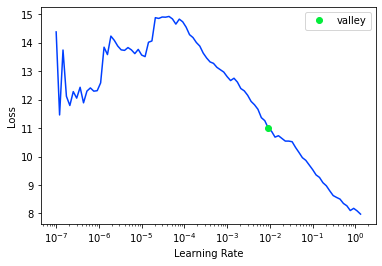

<Figure size 720x720 with 0 Axes>

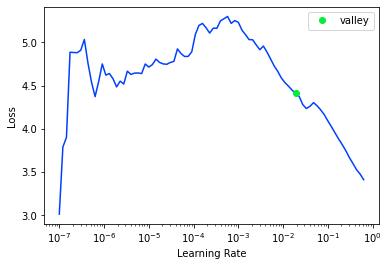

<Figure size 720x720 with 0 Axes>

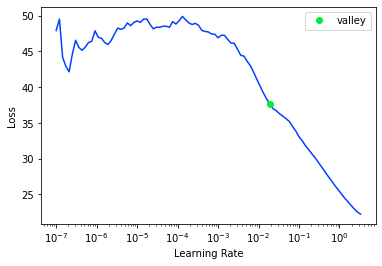

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.00      -0.00
1   21.56      21.81
2    0.00      -0.00
3    0.00      -0.00
4    0.00       0.00
XGBoost RMSE:  51.58753


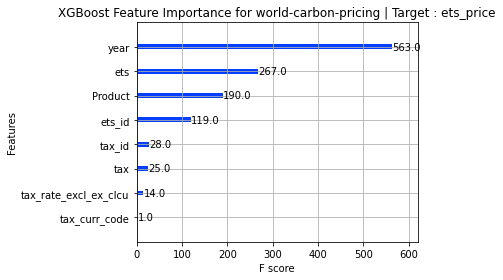

Target Variable: ets_id
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 311


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01574993133544922}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03406977653503418}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012175559997558594}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010491609573364258}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.00985860824584961}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012931346893310547}


 24%|██▍       | 10/42 [00:00<00:01, 22.90it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.18880510330200195}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012480020523071289}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.11990928649902344}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011831283569335938}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.1305439397334531, 'Time taken': 0.07999992370605469}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.13376283645629883}


 40%|████      | 17/42 [00:00<00:01, 16.39it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.20176410675048828}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 6.101537317311985e-12, 'Time taken': 0.029934406280517578}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0189211368560791}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.9999999999999533, 'Time taken': 0.040817975997924805}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.053710222244262695}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014528989791870117}


 48%|████▊     | 20/42 [00:01<00:01, 14.18it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.19703888893127441}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01558542251586914}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013662099838256836}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01179051399230957}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.600749233841543e-06, 'Time taken': 0.014050483703613281}


 71%|███████▏  | 30/42 [00:01<00:00, 20.17it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.06576619047509721, 'Time taken': 0.20029520988464355}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.026768207550048828}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0263519287109375}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.044011112570103025, 'Time taken': 0.021694660186767578}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015504121780395508}


 79%|███████▊  | 33/42 [00:02<00:00, 10.25it/s]

{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.4921397450962104e-13, 'Time taken': 0.6862461566925049}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02822566032409668}


 83%|████████▎ | 35/42 [00:02<00:00, 10.11it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.19078397750854492}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0123291015625}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01335597038269043}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.0063125365489724045, 'Time taken': 0.011268138885498047}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010340690612792969}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011146306991577148}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010305404663085938}


100%|██████████| 42/42 [00:03<00:00, 13.79it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.9604645e-08, 'Time taken': 0.3564717769622803}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02840423583984375}
Project: world-carbon-pricing
world-carbon-pricing
Target: ets_id
ets_id
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
Lasso                                        1.00       1.00  0.00        0.01
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                      1.00       1.00  0.00        0.01


LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,42.236153,1.061365,1.030226,00:00
1,28.225718,4.071839,2.017880,00:00


Better model found at epoch 0 with _rmse value: 1.0302255153656006.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: tax_curr_code
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
17
Looping through continuous variables to find breakpoint


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 309, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 311


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014973878860473633}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.027672529220581055}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011661767959594727}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010759592056274414}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0108184814453125}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01303863525390625}


 24%|██▍       | 10/42 [00:00<00:01, 25.04it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.1840381622314453}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013117790222167969}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09794139862060547}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011393308639526367}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.25911463533361784, 'Time taken': 0.04393911361694336}


 45%|████▌     | 19/42 [00:00<00:00, 28.14it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.11437344551086426}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05191612243652344}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 7.94041439098631e-11, 'Time taken': 0.02655768394470215}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011016607284545898}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.0000000000000087, 'Time taken': 0.016867637634277344}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.021276235580444336}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.026189088821411133}


 55%|█████▍    | 23/42 [00:00<00:00, 22.59it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.20682859420776367}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011546611785888672}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015670299530029297}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012003183364868164}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 3.7865170238808785e-05, 'Time taken': 0.012496232986450195}


 74%|███████▍  | 31/42 [00:01<00:00, 23.08it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.39096446884554087, 'Time taken': 0.2430863380432129}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02323174476623535}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02196979522705078}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.09327444217461796, 'Time taken': 0.022335529327392578}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.022726058959960938}
{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.474376176702208e-13, 'Time taken': 0.6310343742370605}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squar

 81%|████████  | 34/42 [00:02<00:00,  9.67it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.17741012573242188}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011507272720336914}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010994195938110352}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.007270950353933857, 'Time taken': 0.0108795166015625}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010422945022583008}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011942625045776367}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010996103286743164}


100%|██████████| 42/42 [00:02<00:00, 15.52it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.9604645e-08, 'Time taken': 0.36821413040161133}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03971576690673828}
Project: world-carbon-pricing
world-carbon-pricing
Target: tax_curr_code
tax_curr_code
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
Lasso                                        1.00       1.00  0.00        0.03
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                      1.00       1.00  0.

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,8.344963,1.585921,1.259334,00:00
1,6.829670,13.567957,3.683471,00:00


Better model found at epoch 0 with _rmse value: 1.259333610534668.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: tax_rate_incl_ex_clcu
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'ets_price']
16
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 309, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Tabular Object size: 311


 17%|█▋        | 7/42 [00:00<00:00, 42.55it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.025513648986816406}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.028931617736816406}
{'Model': 'BayesianRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.3650462586617228e-12, 'Time taken': 0.011621236801147461}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011053800582885742}
{'Model': 'DummyRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 3.2989252, 'Time taken': 0.009992122650146484}
{'Model': 'ElasticNet', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.5690600301050966, 'Time taken': 0.011125564575195312}
{'Model': 'ElasticNetCV', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.06603834681364625, 'Time taken': 0.06580758094787598}
{'Model': 'ExtraTreeRe

 29%|██▊       | 12/42 [00:00<00:01, 22.78it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.00019658230023405943, 'Time taken': 0.1437685489654541}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 4.426924394716744, 'Time taken': 0.16106414794921875}


 36%|███▌      | 15/42 [00:00<00:01, 18.49it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.82225892428086e-08, 'Time taken': 0.057317495346069336}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01267695426940918}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 3.2975226881589954, 'Time taken': 0.037653207778930664}
{'Model': 'Lars', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.773159728050814e-15, 'Time taken': 0.06047344207763672}


 43%|████▎     | 18/42 [00:00<00:01, 18.39it/s]

{'Model': 'LarsCV', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.773159728050814e-15, 'Time taken': 0.06523871421813965}
{'Model': 'Lasso', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.11103172366197489, 'Time taken': 0.015089035034179688}


 52%|█████▏    | 22/42 [00:00<00:00, 22.15it/s]

{'Model': 'LassoCV', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.0032989247752492905, 'Time taken': 0.06807923316955566}
{'Model': 'LassoLars', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.7520510469669113, 'Time taken': 0.013061046600341797}
{'Model': 'LassoLarsCV', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.773159728050814e-15, 'Time taken': 0.01668858528137207}
{'Model': 'LassoLarsIC', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.773159728050814e-15, 'Time taken': 0.012799263000488281}
{'Model': 'LinearRegression', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 8.5942005528184e-15, 'Time taken': 0.010848522186279297}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.1907496752199275e-07, 'Time taken': 0.012705802917480469}


 69%|██████▉   | 29/42 [00:01<00:01, 12.40it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.4255416560321113, 'Time taken': 0.7301032543182373}
{'Model': 'NuSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.010319038062215829, 'Time taken': 0.058867454528808594}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 9.769962616701378e-15, 'Time taken': 0.025524139404296875}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 9.769962616701378e-15, 'Time taken': 0.02817392349243164}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.056914455075038624, 'Time taken': 0.014006853103637695}
{'Model': 'PoissonRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.2405226717243889, 'Time taken': 0.016467809677124023}


 76%|███████▌  | 32/42 [00:03<00:02,  4.73it/s]

{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 3.5636380819761396e-12, 'Time taken': 1.6189348697662354}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.043415069580078125}


 81%|████████  | 34/42 [00:03<00:01,  5.21it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.19080710411071777}
{'Model': 'Ridge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.0176720035149338, 'Time taken': 0.014836788177490234}
{'Model': 'RidgeCV', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.0017859592057579542, 'Time taken': 0.014539003372192383}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.03818140258271157, 'Time taken': 0.015177726745605469}
{'Model': 'SVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.07254368077747395, 'Time taken': 0.019446611404418945}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 8.5942005528184e-15, 'Time taken': 0.013605117797851562}
{'Model': 'TweedieRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.1969245732549998,

100%|██████████| 42/42 [00:04<00:00,  9.65it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.1918617e-05, 'Time taken': 0.41191935539245605}
{'Model': 'LGBMRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 4.376554384429786, 'Time taken': 0.061658620834350586}
Project: world-carbon-pricing
world-carbon-pricing
Target: tax_rate_incl_ex_clcu
tax_rate_incl_ex_clcu
Target Standard Deviation: 29.71155548095703
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.03
RANSACRegressor                              1.00       1.00  0.00        0.04
DecisionTreeRegressor                        1.00       1.00  0.00        0.01
BaggingRegressor                             1.00       1.00  0.00        0.03
ExtraTreeRegressor                           1.00       1.00  0.00        0.02
Ext

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,1171.616089,0.062540,0.250080,00:00
1,1145.070801,2.844086,1.686442,00:00


Better model found at epoch 0 with _rmse value: 0.250079870223999.
No improvement since epoch 0: early stopping


,jurisdiction,ipcc_code,Product,tax,ets,tax_id,tax_ex_rate,tax_curr_code,ets_id,ets_curr_code,ets_2_id,ets_2_price,ets_2_curr_code,year,tax_rate_excl_ex_clcu,ets_price,tax_rate_incl_ex_clcu,tax_rate_incl_ex_clcu_pred
0,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.09,-0.11,-0.17,0.00,0.01
1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.27,-0.11,-0.17,0.00,0.15
2,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.93,-0.11,-0.17,0.00,-0.52
3,1.00,1.00,4.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.69,-0.11,0.04,0.00,0.28
4,1.00,5.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.78,-0.11,-0.17,0.00,0.11
5,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.06,-0.11,0.62,0.00,0.38
6,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.36,-0.11,-0.17,0.00,0.11
7,1.00,8.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.78,-0.11,-0.17,0.00,0.16
8,1.00,6.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.69,-0.11,-0.17,0.00,0.30


<Figure size 432x288 with 0 Axes>

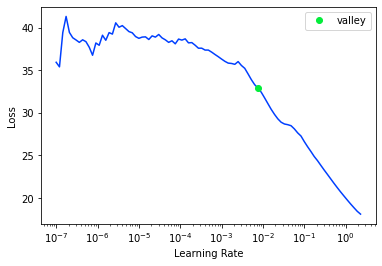

<Figure size 720x720 with 0 Axes>

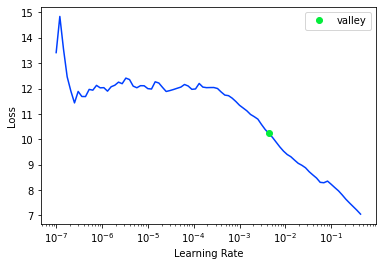

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.00       0.00
1    0.00       0.00
2    0.00       0.00
3    0.00       0.00
4    0.00       0.00
XGBoost RMSE:  1.1918617e-05


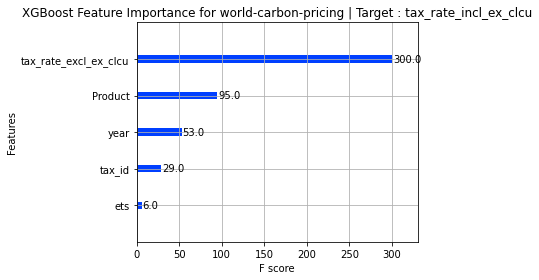

Target Variable: tax_ex_rate
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 311


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.016726970672607422}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.028266191482543945}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011413812637329102}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010766744613647461}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010185003280639648}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01290750503540039}


 24%|██▍       | 10/42 [00:00<00:01, 25.01it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.18087315559387207}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013450145721435547}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0993797779083252}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011380434036254883}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.25979007604013626, 'Time taken': 0.044785261154174805}


 45%|████▌     | 19/42 [00:00<00:00, 29.42it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07160544395446777}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.062196969985961914}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 6.310185613190936e-11, 'Time taken': 0.027836084365844727}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01103520393371582}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.9999999999999868, 'Time taken': 0.017199039459228516}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.021784067153930664}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0265810489654541}


 55%|█████▍    | 23/42 [00:00<00:00, 23.21it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.20911240577697754}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011449337005615234}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011962175369262695}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012670516967773438}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 4.47495908621506e-05, 'Time taken': 0.010880231857299805}


 71%|███████▏  | 30/42 [00:01<00:00, 23.15it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.16355885703213063, 'Time taken': 0.2042553424835205}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02458047866821289}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.028139352798461914}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.037597278273284414, 'Time taken': 0.0226132869720459}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013079643249511719}


 79%|███████▊  | 33/42 [00:01<00:00, 10.96it/s]

{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.474376176702208e-13, 'Time taken': 0.5958435535430908}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.06790637969970703}


 83%|████████▎ | 35/42 [00:02<00:00, 10.84it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.17212128639221191}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012796878814697266}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015417098999023438}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.006521684484130631, 'Time taken': 0.014335393905639648}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01286768913269043}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0136260986328125}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013908147811889648}


100%|██████████| 42/42 [00:02<00:00, 15.80it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.9604645e-08, 'Time taken': 0.3935232162475586}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.028877735137939453}
Project: world-carbon-pricing
world-carbon-pricing
Target: tax_ex_rate
tax_ex_rate
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
Lasso                                        1.00       1.00  0.00        0.03
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                      1.00       1.00  0.00  

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,14.527711,2.667282,1.633181,00:00
1,11.596351,0.020406,0.142849,00:00
2,9.321653,0.122017,0.349310,00:00


Better model found at epoch 0 with _rmse value: 1.6331814527511597.
Better model found at epoch 1 with _rmse value: 0.1428493708372116.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: tax_rate_excl_ex_clcu
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_incl_ex_clcu', 'ets_price']
16
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 309, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Tabular Object size: 311


 12%|█▏        | 5/42 [00:00<00:00, 45.88it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.4864796439275978, 'Adjusted R-Squared': 0.3038946284351881, 'RMSE': 39.7610655155752, 'Time taken': 0.030737876892089844}
{'Model': 'BaggingRegressor', 'R-Squared': 0.38301251375577405, 'Adjusted R-Squared': 0.16363918531338262, 'RMSE': 43.58302396587187, 'Time taken': 0.032019853591918945}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.9879911952330557e-10, 'Time taken': 0.014724493026733398}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.3941617717929421, 'Adjusted R-Squared': 0.17875262398598812, 'RMSE': 43.18744573592253, 'Time taken': 0.016967058181762695}
{'Model': 'DummyRegressor', 'R-Squared': -0.013344343684191129, 'Adjusted R-Squared': -0.3736445547719036, 'RMSE': 55.85444, 'Time taken': 0.013797998428344727}
{'Model': 'ElasticNet', 'R-Squared': 0.8287465749633989, 'Adjusted R-Squared': 0.7678564682837185, 'RMSE': 22.961423840541755, 'Time taken': 0.016412734985351562}
{'Model': 'ElasticNetCV'

 24%|██▍       | 10/42 [00:00<00:01, 27.39it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.4688724005865823, 'Adjusted R-Squared': 0.280027031906256, 'RMSE': 40.43697103827131, 'Time taken': 0.11458158493041992}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.019378142559661082, 'Adjusted R-Squared': -0.38182370435865165, 'RMSE': 56.020481952196775, 'Time taken': 0.03789234161376953}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.47902100325586794, 'Adjusted R-Squared': 0.2937840266357321, 'RMSE': 40.04877990302237, 'Time taken': 0.13352203369140625}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.03213244390578773, 'Adjusted R-Squared': -0.39911286840562354, 'RMSE': 56.36985232660243, 'Time taken': 0.16617298126220703}


 40%|████      | 17/42 [00:00<00:01, 18.58it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999837773, 'Adjusted R-Squared': 0.9999999999780093, 'RMSE': 0.00022348114068384926, 'Time taken': 0.060262203216552734}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.2312823778782468, 'Adjusted R-Squared': -0.042039443320598835, 'RMSE': 48.64773, 'Time taken': 0.014747858047485352}
{'Model': 'KernelRidge', 'R-Squared': 0.9993251841171776, 'Adjusted R-Squared': 0.999085249581063, 'RMSE': 1.441357891051168, 'Time taken': 0.03732943534851074}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.3418764327206126e-14, 'Time taken': 0.05091047286987305}
{'Model': 'LarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.3418764327206126e-14, 'Time taken': 0.06349802017211914}
{'Model': 'Lasso', 'R-Squared': 0.9908034832901758, 'Adjusted R-Squared': 0.9875336106822382, 'RMSE': 5.3209706613052195, 'Time taken': 0.012923240661621094}


 48%|████▊     | 20/42 [00:00<00:01, 19.22it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9999989866557517, 'Adjusted R-Squared': 0.9999986263555746, 'RMSE': 0.055854437898759005, 'Time taken': 0.06435775756835938}
{'Model': 'LassoLars', 'R-Squared': -0.013344248237957546, 'Adjusted R-Squared': -0.3736444253892315, 'RMSE': 55.8544378987422, 'Time taken': 0.01293802261352539}
{'Model': 'LassoLarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.3418764327206126e-14, 'Time taken': 0.016236305236816406}
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.3418764327206126e-14, 'Time taken': 0.011964559555053711}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.722344524911861e-14, 'Time taken': 0.010398626327514648}
{'Model': 'LinearSVR', 'R-Squared': 0.9999999999748865, 'Adjusted R-Squared': 0.9999999999659573, 'RMSE': 0.0002780562276391313, 'Time taken': 0.010569572448730469}


 69%|██████▉   | 29/42 [00:01<00:00, 13.75it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.801325449063824, 'Adjusted R-Squared': 0.7306856087309614, 'RMSE': 24.731491143844337, 'Time taken': 0.6547858715057373}
{'Model': 'NuSVR', 'R-Squared': -0.012476920361691235, 'Adjusted R-Squared': -0.3724687142680705, 'RMSE': 55.83052969507288, 'Time taken': 0.062347412109375}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 2.6054329108707983e-13, 'Time taken': 0.028839111328125}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 2.6054329108707983e-13, 'Time taken': 0.027999401092529297}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999987720060215, 'Adjusted R-Squared': 0.9999983353859403, 'RMSE': 0.06148615008109263, 'Time taken': 0.01398921012878418}
{'Model': 'PoissonRegressor', 'R-Squared': -662476.1263041213, 'Adjusted R-Squared': -898023.5489900312, 'RMSE': 45161.11190235763, 'Time taken': 0.018139362335205078}


 76%|███████▌  | 32/42 [00:03<00:01,  5.85it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.019625461398227184, 'Adjusted R-Squared': -0.38215895878426354, 'RMSE': 56.02727731090361, 'Time taken': 1.3024451732635498}
{'Model': 'RANSACRegressor', 'R-Squared': -0.01962546139821897, 'Adjusted R-Squared': -0.38215895878425243, 'RMSE': 56.02727731090338, 'Time taken': 0.08471179008483887}


 81%|████████  | 34/42 [00:03<00:01,  6.18it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.35894448425715153, 'Adjusted R-Squared': 0.1310136342152498, 'RMSE': 44.4249556402158, 'Time taken': 0.16232585906982422}
{'Model': 'Ridge', 'R-Squared': 0.9999651538082015, 'Adjusted R-Squared': 0.9999527640511175, 'RMSE': 0.3275343427651593, 'Time taken': 0.015496492385864258}
{'Model': 'RidgeCV', 'R-Squared': 0.9999996467389232, 'Adjusted R-Squared': 0.9999995211349847, 'RMSE': 0.03297820979019705, 'Time taken': 0.013045072555541992}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999936611752169, 'Adjusted R-Squared': 0.9999914073708496, 'RMSE': 0.13969586648442606, 'Time taken': 0.014258861541748047}
{'Model': 'SVR', 'R-Squared': -0.01064971483987609, 'Adjusted R-Squared': -0.36999183567183214, 'RMSE': 55.78012858593233, 'Time taken': 0.01599574089050293}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.722344524911861e-14, 'Time taken': 0.01400899887084961}
{'Model': 'TweedieRegressor', 'R-S

100%|██████████| 42/42 [00:03<00:00, 10.58it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.3946380973014785, 'Adjusted R-Squared': 0.17939830967533743, 'RMSE': 43.170464, 'Time taken': 0.39104294776916504}
{'Model': 'LGBMRegressor', 'R-Squared': -0.032442693928730115, 'Adjusted R-Squared': -0.39953342954783433, 'RMSE': 56.378323833353804, 'Time taken': 0.05961441993713379}
Project: world-carbon-pricing
world-carbon-pricing
Target: tax_rate_excl_ex_clcu
tax_rate_excl_ex_clcu
Target Standard Deviation: 10.497039794921875
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
LassoLarsCV                                  1.00       1.00     0.00   
LinearRegression                             1.00       1.00     0.00   
LarsCV                                       1.00       1.00     0.00   
Lars                                         1.00       1.00     0.00   
OrthogonalMatchingPursuit                    1.00       1.00     0.00   
OrthogonalMatc

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,113.591850,3137.224365,56.010929,00:00
1,126.794762,3130.475586,55.950653,00:00
2,105.569939,3133.250244,55.975445,00:00


Better model found at epoch 0 with _rmse value: 56.010929107666016.
Better model found at epoch 1 with _rmse value: 55.950653076171875.
No improvement since epoch 1: early stopping


,jurisdiction,ipcc_code,Product,tax,ets,tax_id,tax_ex_rate,tax_curr_code,ets_id,ets_curr_code,ets_2_id,ets_2_price,ets_2_curr_code,year,tax_rate_incl_ex_clcu,ets_price,tax_rate_excl_ex_clcu,tax_rate_excl_ex_clcu_pred
0,1.00,1.00,3.00,2.00,2.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.40,2.67,0.31,29.41,0.63
1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.28,-0.13,-0.15,0.00,-0.16
2,1.00,9.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.17,-0.13,-0.15,0.00,0.07
3,1.00,6.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.14,-0.13,-0.15,0.00,0.77
4,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.09,-0.13,0.64,0.00,0.46
5,1.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.70,-0.13,-0.15,0.00,-1.81
6,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.61,-0.13,0.01,0.00,0.63
7,1.00,8.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.54,-0.13,-0.15,0.00,0.51
8,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.70,-0.13,-0.15,0.00,-1.82


<Figure size 432x288 with 0 Axes>

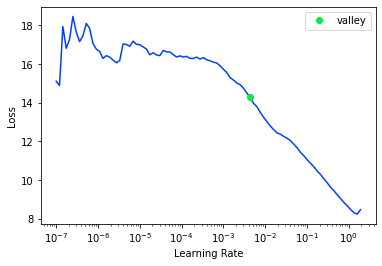

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.00       0.00
1    0.00       0.00
2    0.00       0.00
3    0.00       0.00
4    0.00       0.00
XGBoost RMSE:  43.170464


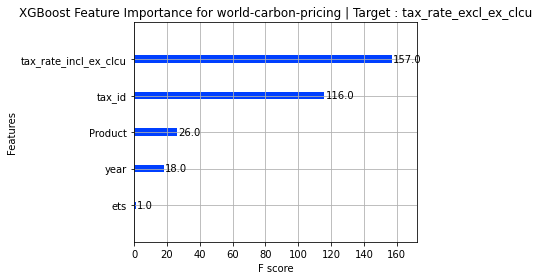

Target Variable: tax_id
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 311


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.017041921615600586}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02918076515197754}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01271367073059082}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012188434600830078}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011518478393554688}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01572585105895996}


 24%|██▍       | 10/42 [00:00<00:01, 24.49it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.18473386764526367}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012158393859863281}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09701061248779297}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012547969818115234}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.20876240866148243, 'Time taken': 0.05550718307495117}


 43%|████▎     | 18/42 [00:00<00:00, 26.92it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07409977912902832}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.06612706184387207}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.0445056579203176e-12, 'Time taken': 0.027961254119873047}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012792587280273438}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.9999999999999986, 'Time taken': 0.02109670639038086}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.025011301040649414}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.035631656646728516}

 52%|█████▏    | 22/42 [00:00<00:00, 21.36it/s]

{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015135049819946289}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01645636558532715}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012921810150146484}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 3.525704599139904e-07, 'Time taken': 0.01324009895324707}


 74%|███████▍  | 31/42 [00:01<00:00, 24.26it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.27858868538872444, 'Time taken': 0.20353960990905762}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.024824857711791992}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0232696533203125}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.1556952042983391, 'Time taken': 0.022404193878173828}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.019109249114990234}
{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 1.4210854715202004e-13, 'Time taken': 0.7734761238098145}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squa

 81%|████████  | 34/42 [00:02<00:00,  8.91it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.17435264587402344}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011501550674438477}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011166810989379883}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 0.006179717645873089, 'Time taken': 0.011127710342407227}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010314702987670898}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011189699172973633}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010800361633300781}


100%|██████████| 42/42 [00:02<00:00, 14.72it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.3555555555555556, 'RMSE': 5.9604645e-08, 'Time taken': 0.4012482166290283}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02799701690673828}
Project: world-carbon-pricing
world-carbon-pricing
Target: tax_id
tax_id
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
Lasso                                        1.00       1.00  0.00        0.04
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                      1.00       1.00  0.00        0.01


LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,25.527010,11.556101,3.399426,00:00
1,17.754879,50.090919,7.077494,00:00


Better model found at epoch 0 with _rmse value: 3.3994264602661133.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: ets
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
17
Looping through continuous variables to find breakpoint


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 309, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 311


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014196157455444336}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02729058265686035}
{'Model': 'BayesianRidge', 'R-Squared': -12.211394438791741, 'Adjusted R-Squared': -16.908779128139916, 'RMSE': 1.3885581461819836, 'Time taken': 0.011548280715942383}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010648488998413086}
{'Model': 'DummyRegressor', 'R-Squared': -0.0005239694684930907, 'Adjusted R-Squared': -0.356265825279513, 'RMSE': 0.3821232737960949, 'Time taken': 0.010016441345214844}
{'Model': 'ElasticNet', 'R-Squared': -0.0005239694684930907, 'Adjusted R-Squared': -0.356265825279513, 'RMSE': 0.3821232737960949, 'Time taken': 0.010439157485961914}


 21%|██▏       | 9/42 [00:00<00:02, 14.28it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -12.591040936531359, 'Adjusted R-Squared': -17.423411047298064, 'RMSE': 1.4083678464795417, 'Time taken': 0.42907166481018066}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014158487319946289}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.10790205001831055}
{'Model': 'GammaRegressor', 'R-Squared': -869.2008748364906, 'Adjusted R-Squared': -1178.6056303339096, 'RMSE': 11.269366389917199, 'Time taken': 0.016891002655029297}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.30118269053627766, 'Adjusted R-Squared': 0.05271431383806524, 'RMSE': 0.31935341748182783, 'Time taken': 0.03614401817321777}


 33%|███▎      | 14/42 [00:00<00:01, 14.86it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992941224, 'Adjusted R-Squared': 0.9999999990431437, 'RMSE': 1.0149728699545487e-05, 'Time taken': 0.12580132484436035}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999999992941224, 'Adjusted R-Squared': 0.9999999990431437, 'RMSE': 1.0149728952941102e-05, 'Time taken': 0.07451486587524414}
{'Model': 'HuberRegressor', 'R-Squared': -34.083868513420306, 'Adjusted R-Squared': -46.55813287374753, 'RMSE': 2.2627859760871525, 'Time taken': 0.06412506103515625}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8452762923351158, 'Adjusted R-Squared': 0.7902634184987125, 'RMSE': 0.15026857675938213, 'Time taken': 0.014866828918457031}
{'Model': 'KernelRidge', 'R-Squared': -19.39641926710095, 'Adjusted R-Squared': -26.648479450959066, 'RMSE': 1.7253082796847974, 'Time taken': 0.038867950439453125}


 48%|████▊     | 20/42 [00:01<00:01, 18.54it/s]

{'Model': 'Lars', 'R-Squared': -12.84087556932809, 'Adjusted R-Squared': -17.762075771755857, 'RMSE': 1.4212534217598065, 'Time taken': 0.046346426010131836}
{'Model': 'LarsCV', 'R-Squared': -11.655945597475899, 'Adjusted R-Squared': -16.15583736546733, 'RMSE': 1.3590550253623042, 'Time taken': 0.06841039657592773}
{'Model': 'Lasso', 'R-Squared': -0.0005239694684930907, 'Adjusted R-Squared': -0.356265825279513, 'RMSE': 0.3821232737960949, 'Time taken': 0.011545419692993164}
{'Model': 'LassoCV', 'R-Squared': -12.671702107502458, 'Adjusted R-Squared': -17.532751745725555, 'RMSE': 1.4125409097156854, 'Time taken': 0.06922030448913574}
{'Model': 'LassoLars', 'R-Squared': -0.0005239694684930907, 'Adjusted R-Squared': -0.356265825279513, 'RMSE': 0.3821232737960949, 'Time taken': 0.015937328338623047}
{'Model': 'LassoLarsCV', 'R-Squared': -11.655945597475899, 'Adjusted R-Squared': -16.15583736546733, 'RMSE': 1.3590550253623042, 'Time taken': 0.02356433868408203}


 60%|█████▉    | 25/42 [00:01<00:00, 25.83it/s]

{'Model': 'LassoLarsIC', 'R-Squared': -12.658527122686886, 'Adjusted R-Squared': -17.514892321864448, 'RMSE': 1.4118601352748765, 'Time taken': 0.023799896240234375}
{'Model': 'LinearRegression', 'R-Squared': -12.916827717409188, 'Adjusted R-Squared': -17.865033128043567, 'RMSE': 1.425147668332013, 'Time taken': 0.011221647262573242}
{'Model': 'LinearSVR', 'R-Squared': -28.917248261731363, 'Adjusted R-Squared': -39.55449208812474, 'RMSE': 2.0895393964685605, 'Time taken': 0.02367258071899414}


 67%|██████▋   | 28/42 [00:02<00:01,  9.63it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5276413097555533, 'Adjusted R-Squared': 0.35969155322419455, 'RMSE': 0.262558266278634, 'Time taken': 0.7128818035125732}
{'Model': 'NuSVR', 'R-Squared': 0.8715788850612486, 'Adjusted R-Squared': 0.825918044194137, 'RMSE': 0.13690142199626437, 'Time taken': 0.08195137977600098}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -16.01802477699981, 'Adjusted R-Squared': -22.068878031044186, 'RMSE': 1.5759568307334118, 'Time taken': 0.022292137145996094}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -13.028416962278042, 'Adjusted R-Squared': -18.01629854886579, 'RMSE': 1.4308498885990624, 'Time taken': 0.019033432006835938}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -30.75840958228764, 'Adjusted R-Squared': -42.0502885448788, 'RMSE': 2.152876483423535, 'Time taken': 0.011085748672485352}
{'Model': 'PoissonRegressor', 'R-Squared': -1832.0951376726528, 'Adjusted R-Squared': -2483.8622977340406, 'RMSE': 16.35619365318816, 'Time tak

 76%|███████▌  | 32/42 [00:03<00:01,  5.91it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.21568627451581435, 'Adjusted R-Squared': -0.6479302832325484, 'RMSE': 0.4212117695881572, 'Time taken': 1.1239192485809326}
{'Model': 'RANSACRegressor', 'R-Squared': -0.21568627450980404, 'Adjusted R-Squared': -0.6479302832244012, 'RMSE': 0.421211769587116, 'Time taken': 0.1384415626525879}


 81%|████████  | 34/42 [00:03<00:01,  5.94it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.19082880020141602}
{'Model': 'Ridge', 'R-Squared': -12.794206705574474, 'Adjusted R-Squared': -17.698813534223177, 'RMSE': 1.4188552971580597, 'Time taken': 0.015628337860107422}
{'Model': 'RidgeCV', 'R-Squared': -11.765389870368109, 'Adjusted R-Squared': -16.304195157610103, 'RMSE': 1.3649186965526128, 'Time taken': 0.012794971466064453}
{'Model': 'SGDRegressor', 'R-Squared': -12.142392872935607, 'Adjusted R-Squared': -16.815243672201603, 'RMSE': 1.3849272607672407, 'Time taken': 0.012798786163330078}
{'Model': 'SVR', 'R-Squared': 0.8557116385181358, 'Adjusted R-Squared': 0.8044091099912507, 'RMSE': 0.1451126897058433, 'Time taken': 0.017264127731323242}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -12.916827717409188, 'Adjusted R-Squared': -17.865033128043567, 'RMSE': 1.425147668332013, 'Time taken': 0.013410329818725586}
{'Model': 'TweedieRegressor', 'R-Squared': -2.4

100%|██████████| 42/42 [00:04<00:00, 10.11it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999823533519, 'Adjusted R-Squared': 0.999999976078988, 'RMSE': 5.0748225e-05, 'Time taken': 0.3858327865600586}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999999992941224, 'Adjusted R-Squared': 0.9999999990431437, 'RMSE': 1.0149728952941102e-05, 'Time taken': 0.04335975646972656}
Project: world-carbon-pricing
world-carbon-pricing
Target: ets
ets
Target Standard Deviation: 0.3744643438053024
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
ExtraTreesRegressor                          1.00       1.00  0.00        0.11
RandomForestRegressor                        1.00       1.00  0.00        0.19
DecisionTreeRegressor                        1.00       1.00  0.00        0.01
BaggingRegressor                             1.00       1.00  0.00        0.03
ExtraTre

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,15.014319,0.441312,0.664313,00:00
1,10.212997,2.424995,1.557239,00:00


Better model found at epoch 0 with _rmse value: 0.6643129587173462.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       2       2.00
2       2       2.00
3       2       2.00
4       1       1.00
XGBoost RMSE:  5.0748225e-05


<Figure size 432x288 with 0 Axes>

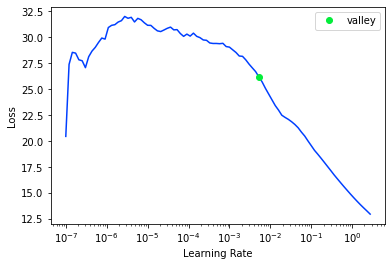

<Figure size 720x720 with 0 Axes>

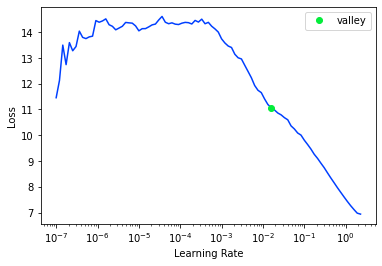

<Figure size 720x720 with 0 Axes>

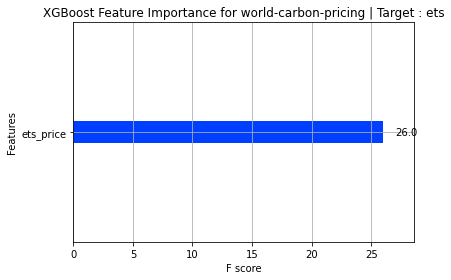

Target Variable: tax
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 311


  5%|▍         | 2/42 [00:00<00:02, 17.71it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.838688542343513, 'Adjusted R-Squared': 0.7813333573989842, 'RMSE': 0.10936122047238628, 'Time taken': 0.08492493629455566}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8150877192982455, 'Adjusted R-Squared': 0.7493411306042883, 'RMSE': 0.1170883316960099, 'Time taken': 0.027805089950561523}
{'Model': 'BayesianRidge', 'R-Squared': 0.24066467235475286, 'Adjusted R-Squared': -0.029321221919112794, 'RMSE': 0.2372725749268291, 'Time taken': 0.013845443725585938}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7824561403508771, 'Adjusted R-Squared': 0.7051072124756333, 'RMSE': 0.1270001270001905, 'Time taken': 0.010398149490356445}
{'Model': 'DummyRegressor', 'R-Squared': -0.01793796761059685, 'Adjusted R-Squared': -0.3798714672054757, 'RMSE': 0.2747207080321783, 'Time taken': 0.010154485702514648}
{'Model': 'ElasticNet', 'R-Squared': -0.01793796761059685, 'Adjusted R-Squared': -0.3798714672054757, 'RMSE': 0.2747207080321783, 'Time taken': 0.01

 17%|█▋        | 7/42 [00:00<00:01, 33.36it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.21616254433480953, 'Adjusted R-Squared': -0.06253521767948045, 'RMSE': 0.24107032129377406, 'Time taken': 0.06634712219238281}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7824561403508771, 'Adjusted R-Squared': 0.7051072124756333, 'RMSE': 0.1270001270001905, 'Time taken': 0.011985301971435547}


 26%|██▌       | 11/42 [00:00<00:01, 27.04it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7625291228070175, 'Adjusted R-Squared': 0.6780950331384015, 'RMSE': 0.13268930481731836, 'Time taken': 0.10971331596374512}
{'Model': 'GammaRegressor', 'R-Squared': 0.153310180814214, 'Adjusted R-Squared': -0.14773508822962111, 'RMSE': 0.25054913595660777, 'Time taken': 0.013711214065551758}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.0559232606816993, 'Adjusted R-Squared': -4.498029308924082, 'RMSE': 0.5483724213630006, 'Time taken': 0.04242730140686035}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7824120647199948, 'Adjusted R-Squared': 0.7050474655093263, 'RMSE': 0.12701299182485257, 'Time taken': 0.11289286613464355}


 43%|████▎     | 18/42 [00:01<00:02,  8.79it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.13511356024125887, 'Adjusted R-Squared': -0.17240161833962686, 'RMSE': 0.2532271601213259, 'Time taken': 1.1014225482940674}
{'Model': 'HuberRegressor', 'R-Squared': 0.14772568980884404, 'Adjusted R-Squared': -0.15530517603690042, 'RMSE': 0.2513740483343163, 'Time taken': 0.04584145545959473}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6693333333333332, 'Adjusted R-Squared': 0.5517629629629628, 'RMSE': 0.15657627225176254, 'Time taken': 0.01318979263305664}
{'Model': 'KernelRidge', 'R-Squared': -15.286834146381466, 'Adjusted R-Squared': -21.07770850953932, 'RMSE': 1.0988769846521533, 'Time taken': 0.024028539657592773}
{'Model': 'Lars', 'R-Squared': 0.26805884481773434, 'Adjusted R-Squared': 0.007813100752928737, 'RMSE': 0.23295327696210757, 'Time taken': 0.03180360794067383}
{'Model': 'LarsCV', 'R-Squared': -0.01793796761059685, 'Adjusted R-Squared': -0.3798714672054757, 'RMSE': 0.2747207080321783, 'Time taken': 0.057741403

 50%|█████     | 21/42 [00:01<00:01, 10.89it/s]

{'Model': 'Lasso', 'R-Squared': -0.01793796761059685, 'Adjusted R-Squared': -0.3798714672054757, 'RMSE': 0.2747207080321783, 'Time taken': 0.02642202377319336}
{'Model': 'LassoCV', 'R-Squared': 0.213299549525501, 'Adjusted R-Squared': -0.06641616619876545, 'RMSE': 0.2415101790679902, 'Time taken': 0.07458829879760742}
{'Model': 'LassoLars', 'R-Squared': -0.01793796761059685, 'Adjusted R-Squared': -0.3798714672054757, 'RMSE': 0.2747207080321783, 'Time taken': 0.013866186141967773}
{'Model': 'LassoLarsCV', 'R-Squared': -0.01793796761059685, 'Adjusted R-Squared': -0.3798714672054757, 'RMSE': 0.2747207080321783, 'Time taken': 0.028992414474487305}
{'Model': 'LassoLarsIC', 'R-Squared': 0.25962381315235195, 'Adjusted R-Squared': -0.0036210532823675035, 'RMSE': 0.23429173120275562, 'Time taken': 0.01584148406982422}
{'Model': 'LinearRegression', 'R-Squared': 0.26805884481773334, 'Adjusted R-Squared': 0.007813100752927404, 'RMSE': 0.23295327696210774, 'Time taken': 0.013000249862670898}
{'Mode

 67%|██████▋   | 28/42 [00:02<00:01,  9.93it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6596782144713635, 'Adjusted R-Squared': 0.5386749129500705, 'RMSE': 0.1588457560441303, 'Time taken': 0.6335108280181885}
{'Model': 'NuSVR', 'R-Squared': 0.6113683382670236, 'Adjusted R-Squared': 0.4731881918730765, 'RMSE': 0.16974610991076716, 'Time taken': 0.06547665596008301}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.23795192415986544, 'Adjusted R-Squared': -0.03299850280551575, 'RMSE': 0.23769602875294638, 'Time taken': 0.029716014862060547}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.26136748647533425, 'Adjusted R-Squared': -0.0012574072223248134, 'RMSE': 0.23401567622862646, 'Time taken': 0.021944761276245117}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.4247034525754172, 'Adjusted R-Squared': 0.2201535690466766, 'RMSE': 0.20652689908529398, 'Time taken': 0.015522956848144531}
{'Model': 'PoissonRegressor', 'R-Squared': 0.1619464207662603, 'Adjusted R-Squared': -0.1360281851835139, 'RMSE': 0.249268059682631

 76%|███████▌  | 32/42 [00:04<00:02,  4.60it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.08771929824527902, 'Adjusted R-Squared': -0.4744639376213784, 'RMSE': 0.2839809171234886, 'Time taken': 1.6641168594360352}
{'Model': 'RANSACRegressor', 'R-Squared': -0.08771929824561453, 'Adjusted R-Squared': -0.47446393762183314, 'RMSE': 0.2839809171235324, 'Time taken': 0.03927254676818848}


 81%|████████  | 34/42 [00:04<00:01,  5.06it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8984940350877193, 'Adjusted R-Squared': 0.8624030253411306, 'RMSE': 0.08675140604977478, 'Time taken': 0.19259381294250488}
{'Model': 'Ridge', 'R-Squared': 0.2675695156164095, 'Adjusted R-Squared': 0.007149787835577293, 'RMSE': 0.23303113280801, 'Time taken': 0.012990474700927734}
{'Model': 'RidgeCV', 'R-Squared': 0.26325280168981147, 'Adjusted R-Squared': 0.0012982422906332447, 'RMSE': 0.23371682991704593, 'Time taken': 0.011279106140136719}
{'Model': 'SGDRegressor', 'R-Squared': 0.2567460786501088, 'Adjusted R-Squared': -0.007521982274297123, 'RMSE': 0.23474661854429552, 'Time taken': 0.010993719100952148}
{'Model': 'SVR', 'R-Squared': 0.5832044799346819, 'Adjusted R-Squared': 0.435010517244791, 'RMSE': 0.1757892291198804, 'Time taken': 0.013250350952148438}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.26805884481773334, 'Adjusted R-Squared': 0.007813100752927404, 'RMSE': 0.23295327696210774, 'Time taken': 0.0110089778900146

100%|██████████| 42/42 [00:05<00:00,  8.03it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.7834275906836203, 'Adjusted R-Squared': 0.7064240673711297, 'RMSE': 0.12671626, 'Time taken': 0.4042072296142578}
{'Model': 'LGBMRegressor', 'R-Squared': 0.15288940648737936, 'Adjusted R-Squared': -0.14830547120599702, 'RMSE': 0.25061138516926157, 'Time taken': 0.059241294860839844}
Project: world-carbon-pricing
world-carbon-pricing
Target: tax
tax
Target Standard Deviation: 0.20548753101150252
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.86       0.90  0.09        0.19
AdaBoostRegressor                            0.78       0.84  0.11        0.08
BaggingRegressor                             0.75       0.82  0.12        0.03
XGBRegressor                                 0.71       0.78  0.13        0.40
DecisionTreeRegressor                        0.71       0.78  0.13        0.01
ExtraTre

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,16.951151,1.770819,1.330721,00:00
1,11.412375,6.974630,2.640952,00:00


Better model found at epoch 0 with _rmse value: 1.3307212591171265.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       2       2.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.12671626


<Figure size 432x288 with 0 Axes>

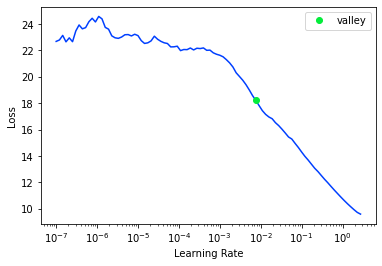

<Figure size 720x720 with 0 Axes>

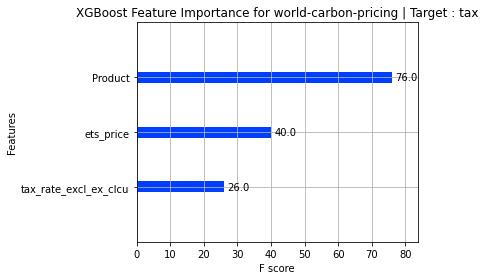

Target Variable: Product
CATS=====================
['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'ipcc_code', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 226


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012923479080200195}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0270082950592041}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010912656784057617}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010286569595336914}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01031947135925293}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011947870254516602}


 24%|██▍       | 10/42 [00:00<00:01, 25.75it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.16931438446044922}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013578176498413086}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.10089564323425293}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013814449310302734}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.5714285714285714, 'RMSE': 0.00015044860456668433, 'Time taken': 0.028715133666992188}


 31%|███       | 13/42 [00:00<00:01, 19.70it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.08320784568786621}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.10460186004638672}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.5714285714285714, 'RMSE': 5.044865811897475e-12, 'Time taken': 0.02732372283935547}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01445460319519043}


 38%|███▊      | 16/42 [00:00<00:01, 21.61it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.5714285714285714, 'RMSE': 0.9999999999999897, 'Time taken': 0.06473970413208008}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.06659173965454102}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014468908309936523}


 48%|████▊     | 20/42 [00:00<00:01, 18.45it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.16756439208984375}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011686563491821289}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011492252349853516}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011392831802368164}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.5714285714285714, 'RMSE': 3.6099699001032523e-07, 'Time taken': 0.011194467544555664}
{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.5714285714285714, 'RMSE': 0.0961992700490136, 'Time taken': 0.14387011528015137}


 74%|███████▍  | 31/42 [00:01<00:00, 26.94it/s]

{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0231931209564209}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.024367570877075195}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.5714285714285714, 'RMSE': 0.06357363523211496, 'Time taken': 0.022951364517211914}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.020907163619995117}
{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.5714285714285714, 'RMSE': 2.327027459614328e-13, 'Time taken': 0.33857107162475586}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.055145978927612305}


 81%|████████  | 34/42 [00:01<00:00, 13.71it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.17708158493041992}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012621402740478516}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010721683502197266}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.5714285714285714, 'RMSE': 0.010663202496237638, 'Time taken': 0.010957717895507812}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01034855842590332}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011181831359863281}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010984659194946289}


100%|██████████| 42/42 [00:02<00:00, 17.96it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.5714285714285714, 'RMSE': 5.9604645e-08, 'Time taken': 0.36898255348205566}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.028003454208374023}
Project: world-carbon-pricing
world-carbon-pricing
Target: Product
Product
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
Lasso                                        1.00       1.00  0.00        0.01
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                      1.00       1.00  0.00        0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,7.079289,0.897782,0.947514,00:00
1,6.972733,0.043312,0.208116,00:00
2,6.574769,0.037397,0.193382,00:00
3,5.872604,0.775006,0.880344,00:00


Better model found at epoch 0 with _rmse value: 0.9475138187408447.
Better model found at epoch 1 with _rmse value: 0.20811612904071808.
Better model found at epoch 2 with _rmse value: 0.19338221848011017.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: ipcc_code
CATS=====================
['jurisdiction', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
16
Looping through continuous variables to find breakpoint


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4034983974.py", line 309, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Continuous variables that made the cut : ['year', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 182


 14%|█▍        | 6/42 [00:00<00:00, 56.08it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.26233208244761896, 'Adjusted R-Squared': -1.3253485729298244, 'RMSE': 36995.95716221694, 'Time taken': 0.023656845092773438}
{'Model': 'BaggingRegressor', 'R-Squared': -1.1412287044650675, 'Adjusted R-Squared': -2.944368666119861, 'RMSE': 48183.57130898856, 'Time taken': 0.03259897232055664}
{'Model': 'BayesianRidge', 'R-Squared': -0.1255978043726087, 'Adjusted R-Squared': -1.0734696396337529, 'RMSE': 34934.86557798863, 'Time taken': 0.013072967529296875}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.3884370548953693, 'Adjusted R-Squared': -3.399752469544101, 'RMSE': 50889.0517030057, 'Time taken': 0.012292146682739258}
{'Model': 'DummyRegressor', 'R-Squared': -0.12559778666277022, 'Adjusted R-Squared': -1.0734696070103662, 'RMSE': 34934.863, 'Time taken': 0.012135505676269531}
{'Model': 'ElasticNet', 'R-Squared': -0.12433001962103107, 'Adjusted R-Squared': -1.0711342466703204, 'RMSE': 34915.186093942204, 'Time taken': 0.0121467113494

 29%|██▊       | 12/42 [00:00<00:01, 25.53it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.8859098955357141, 'Adjusted R-Squared': -2.4740445444078945, 'RMSE': 45219.72610770736, 'Time taken': 0.08627057075500488}


 38%|███▊      | 16/42 [00:00<00:01, 24.17it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.5537288423646947, 'Adjusted R-Squared': -1.862132078040227, 'RMSE': 41044.50966425081, 'Time taken': 0.13391852378845215}
{'Model': 'HuberRegressor', 'R-Squared': -0.03497858889922867, 'Adjusted R-Squared': -0.906539505867, 'RMSE': 33499.100102328004, 'Time taken': 0.017145156860351562}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.7273948760939017, 'Adjusted R-Squared': -2.1820431928045556, 'RMSE': 43277.61, 'Time taken': 0.011071920394897461}
{'Model': 'KernelRidge', 'R-Squared': -0.061677932425041826, 'Adjusted R-Squared': -0.9557225070987612, 'RMSE': 33928.43698869085, 'Time taken': 0.01621103286743164}
{'Model': 'Lars', 'R-Squared': -0.1485463335774957, 'Adjusted R-Squared': -1.1157432460638077, 'RMSE': 35289.192254740585, 'Time taken': 0.02294611930847168}
{'Model': 'LarsCV', 'R-Squared': -0.13134753202838456, 'Adjusted R-Squared': -1.084061243210182, 'RMSE': 35023.97827057577, 'Time taken': 0.03875589370727539}
{'Mode

 48%|████▊     | 20/42 [00:00<00:00, 24.19it/s]

{'Model': 'LassoCV', 'R-Squared': -0.13426018912340698, 'Adjusted R-Squared': -1.089426664174697, 'RMSE': 35069.03395073775, 'Time taken': 0.0789482593536377}
{'Model': 'LassoLars', 'R-Squared': -0.1483934271646068, 'Adjusted R-Squared': -1.1154615763558544, 'RMSE': 35286.843144719234, 'Time taken': 0.013065099716186523}
{'Model': 'LassoLarsCV', 'R-Squared': -0.13134753202838456, 'Adjusted R-Squared': -1.084061243210182, 'RMSE': 35023.97827057577, 'Time taken': 0.019516468048095703}
{'Model': 'LassoLarsIC', 'R-Squared': -0.12559780795612618, 'Adjusted R-Squared': -1.0734696462349693, 'RMSE': 34934.86563359895, 'Time taken': 0.013224363327026367}
{'Model': 'LinearRegression', 'R-Squared': -0.14974853169396862, 'Adjusted R-Squared': -1.1179578215415211, 'RMSE': 35307.65624850125, 'Time taken': 0.010947704315185547}
{'Model': 'LinearSVR', 'R-Squared': -0.035099813612376574, 'Adjusted R-Squared': -0.9067628145491147, 'RMSE': 33501.06188199165, 'Time taken': 0.013290643692016602}


 71%|███████▏  | 30/42 [00:01<00:00, 21.76it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.03498591395599071, 'Adjusted R-Squared': -0.9065529993926145, 'RMSE': 33499.21864699076, 'Time taken': 0.35244107246398926}
{'Model': 'NuSVR', 'R-Squared': -0.03397657498187456, 'Adjusted R-Squared': -0.9046936907560847, 'RMSE': 33482.88010841744, 'Time taken': 0.025915861129760742}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.17320448219905038, 'Adjusted R-Squared': -1.1611661514193035, 'RMSE': 35665.99256007649, 'Time taken': 0.021820068359375}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.17320448219905038, 'Adjusted R-Squared': -1.1611661514193035, 'RMSE': 35665.99256007649, 'Time taken': 0.033274173736572266}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.035066164689602886, 'Adjusted R-Squared': -0.9067008296913737, 'RMSE': 33500.51735295649, 'Time taken': 0.02315664291381836}
{'Model': 'PoissonRegressor', 'R-Squared': -0.1345454677047604, 'Adjusted R-Squared': -1.0899521773508742, 'RMSE': 35073.443792224614,

 79%|███████▊  | 33/42 [00:02<00:01,  8.81it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.03508772026821494, 'Adjusted R-Squared': -0.9067405373361854, 'RMSE': 33500.86618054858, 'Time taken': 0.8345131874084473}
{'Model': 'RANSACRegressor', 'R-Squared': -0.03511108957077225, 'Adjusted R-Squared': -0.9067835860514226, 'RMSE': 33501.244354998715, 'Time taken': 0.14313149452209473}


 83%|████████▎ | 35/42 [00:02<00:00,  9.15it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.9812145971137716, 'Adjusted R-Squared': -2.6496058367885267, 'RMSE': 46348.236827444634, 'Time taken': 0.16529512405395508}
{'Model': 'Ridge', 'R-Squared': -0.1489860746120708, 'Adjusted R-Squared': -1.1165532953380253, 'RMSE': 35295.947150210435, 'Time taken': 0.014156579971313477}
{'Model': 'RidgeCV', 'R-Squared': -0.14305041527318996, 'Adjusted R-Squared': -1.1056191860295606, 'RMSE': 35204.65971020493, 'Time taken': 0.01566624641418457}
{'Model': 'SGDRegressor', 'R-Squared': -0.14806214627321967, 'Adjusted R-Squared': -1.114851322082247, 'RMSE': 35281.75312080002, 'Time taken': 0.012010335922241211}
{'Model': 'SVR', 'R-Squared': -0.03506278277251429, 'Adjusted R-Squared': -0.9066945998441052, 'RMSE': 33500.462624056774, 'Time taken': 0.011972665786743164}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.14974853169396862, 'Adjusted R-Squared': -1.1179578215415211, 'RMSE': 35307.65624850125, 'Time taken': 0.010944128036499023

100%|██████████| 42/42 [00:03<00:00, 13.26it/s]

{'Model': 'XGBRegressor', 'R-Squared': -1.1994613062168975, 'Adjusted R-Squared': -3.0516392482942845, 'RMSE': 48834.375, 'Time taken': 0.5243287086486816}
{'Model': 'LGBMRegressor', 'R-Squared': -0.5814448495106945, 'Adjusted R-Squared': -1.913187880677595, 'RMSE': 41408.97528146031, 'Time taken': 0.07951641082763672}
Project: world-carbon-pricing
world-carbon-pricing
Target: ipcc_code
ipcc_code
Target Standard Deviation: 54720.91015625
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
NuSVR                                       -0.90      -0.03 33482.88   
HuberRegressor                              -0.91      -0.03 33499.10   
MLPRegressor                                -0.91      -0.03 33499.22   
SVR                                         -0.91      -0.04 33500.46   
PassiveAggressiveRegressor                  -0.91      -0.04 33500.52   
QuantileRegressor                           -0.

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,3150429952.000000,1122326144.000000,33501.136719,00:00
1,3308128000.000000,1122305536.000000,33500.828125,00:00
2,3360623360.000000,1122243200.000000,33499.898438,00:00
3,3301353984.000000,1122073728.000000,33497.367188,00:00
4,3269776640.000000,1121587968.000000,33490.117188,00:00
5,3189447168.000000,1121041920.000000,33481.964844,00:00
6,3132812800.000000,1119065216.000000,33452.433594,00:00
7,3177716480.000000,1117911552.000000,33435.183594,00:00
8,3213639168.000000,1114544256.000000,33384.789062,00:00
9,3280041984.000000,1097083136.000000,33122.246094,00:00


Better model found at epoch 0 with _rmse value: 33501.13671875.
Better model found at epoch 1 with _rmse value: 33500.828125.
Better model found at epoch 2 with _rmse value: 33499.8984375.
Better model found at epoch 3 with _rmse value: 33497.3671875.
Better model found at epoch 4 with _rmse value: 33490.1171875.
Better model found at epoch 5 with _rmse value: 33481.96484375.
Better model found at epoch 6 with _rmse value: 33452.43359375.
Better model found at epoch 7 with _rmse value: 33435.18359375.
Better model found at epoch 8 with _rmse value: 33384.7890625.
Better model found at epoch 9 with _rmse value: 33122.24609375.
No improvement since epoch 9: early stopping


,jurisdiction,Product,tax,ets,tax_id,tax_ex_rate,tax_curr_code,ets_id,ets_curr_code,ets_2_id,ets_2_price,ets_2_curr_code,year,tax_rate_excl_ex_clcu,tax_rate_incl_ex_clcu,ets_price,ipcc_code,ipcc_code_pred
0,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.28,0.17,0.17,-0.15,0.00,947.67
1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.34,-0.10,-0.10,-0.15,4.00,1089.22
2,1.00,1.00,2.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.42,0.71,0.71,0.21,0.00,991.29
3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.31,-0.10,-0.10,-0.15,0.00,1109.55
4,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.56,-0.10,-0.10,-0.15,4.00,1109.55
5,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.64,-0.10,-0.10,-0.15,4.00,1109.55
6,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.85,-0.10,-0.10,-0.15,20.00,2280.17
7,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.77,-0.10,-0.10,-0.15,2.00,1109.55
8,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.10,-0.10,-0.15,0.00,2264.77


<Figure size 432x288 with 0 Axes>

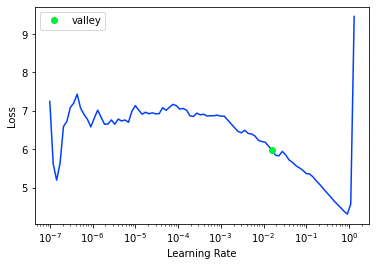

<Figure size 720x720 with 0 Axes>

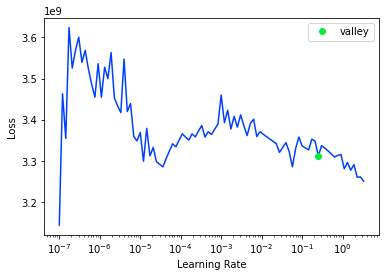

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    4.00     557.04
1    2.00       6.31
2 2000.00      31.45
3    2.00   66733.50
4    4.00   40033.86
XGBoost RMSE:  48834.375


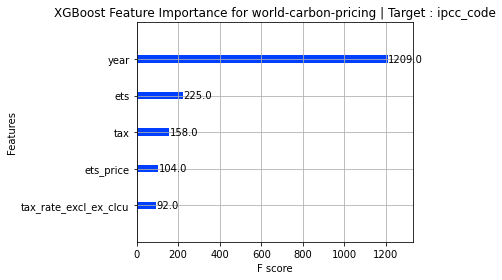

Target Variable: year
CATS=====================
['jurisdiction', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
CONTS=====================
['ipcc_code', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
16
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['ipcc_code', 'tax_rate_excl_ex_clcu', 'tax_rate_incl_ex_clcu', 'ets_price']
Categorical variables that made the cut : ['jurisdiction', 'Product', 'tax', 'ets', 'tax_id', 'tax_ex_rate', 'tax_curr_code', 'ets_id', 'ets_curr_code', 'ets_2_id', 'ets_2_price', 'ets_2_curr_code']
Tabular Object size: 182


 17%|█▋        | 7/42 [00:00<00:00, 41.71it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.03215634031458736, 'Adjusted R-Squared': -0.782869899420497, 'RMSE': 8.328213600306615, 'Time taken': 0.02544260025024414}
{'Model': 'BaggingRegressor', 'R-Squared': -0.03963713339964414, 'Adjusted R-Squared': -0.9151210352098706, 'RMSE': 8.631576862720772, 'Time taken': 0.028637170791625977}
{'Model': 'BayesianRidge', 'R-Squared': 0.05924993303854964, 'Adjusted R-Squared': -0.7329606496658296, 'RMSE': 8.210817128397222, 'Time taken': 0.011378765106201172}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.016605326525000574, 'Adjusted R-Squared': -0.8726940225460535, 'RMSE': 8.53543070951104, 'Time taken': 0.010415077209472656}
{'Model': 'DummyRegressor', 'R-Squared': -0.02441239073308865, 'Adjusted R-Squared': -0.8870754566135843, 'RMSE': 8.56814213054576, 'Time taken': 0.009576559066772461}
{'Model': 'ElasticNet', 'R-Squared': 0.04831000952350639, 'Adjusted R-Squared': -0.7531131403514355, 'RMSE': 8.258421, 'Time taken': 0.01333427429199

 29%|██▊       | 12/42 [00:00<00:01, 25.78it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.007336060761442442, 'Adjusted R-Squared': -0.8285914670183954, 'RMSE': 8.434325809917452, 'Time taken': 0.08932161331176758}


 36%|███▌      | 15/42 [00:00<00:01, 23.39it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.009934564377518829, 'Adjusted R-Squared': -0.8604057764849031, 'RMSE': 8.507380719022747, 'Time taken': 0.12288713455200195}
{'Model': 'HuberRegressor', 'R-Squared': 0.05508728078373981, 'Adjusted R-Squared': -0.7406286932931108, 'RMSE': 8.228962782749948, 'Time taken': 0.020598173141479492}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.12263749515483102, 'Adjusted R-Squared': -1.06801643844311, 'RMSE': 8.969516275821247, 'Time taken': 0.010469913482666016}
{'Model': 'KernelRidge', 'R-Squared': -56192.27827425818, 'Adjusted R-Squared': -103512.93366310716, 'RMSE': 2006.7413, 'Time taken': 0.02682018280029297}


 43%|████▎     | 18/42 [00:00<00:00, 24.84it/s]

{'Model': 'Lars', 'R-Squared': 0.0804780165478054, 'Adjusted R-Squared': -0.6938562853066743, 'RMSE': 8.11765, 'Time taken': 0.026922225952148438}
{'Model': 'LarsCV', 'R-Squared': 0.011542428453186204, 'Adjusted R-Squared': -0.8208428949546569, 'RMSE': 8.416436, 'Time taken': 0.04771709442138672}
{'Model': 'Lasso', 'R-Squared': 0.05063287859313326, 'Adjusted R-Squared': -0.7488341710126492, 'RMSE': 8.248336, 'Time taken': 0.02675628662109375}


 50%|█████     | 21/42 [00:00<00:00, 25.30it/s]

{'Model': 'LassoCV', 'R-Squared': 0.05586408267157095, 'Adjusted R-Squared': -0.7391977424471061, 'RMSE': 8.22558, 'Time taken': 0.06984877586364746}
{'Model': 'LassoLars', 'R-Squared': -0.024411154735961116, 'Adjusted R-Squared': -0.8870731797767704, 'RMSE': 8.568136, 'Time taken': 0.013420581817626953}
{'Model': 'LassoLarsCV', 'R-Squared': 0.011542428453186204, 'Adjusted R-Squared': -0.8208428949546569, 'RMSE': 8.416436, 'Time taken': 0.025887727737426758}
{'Model': 'LassoLarsIC', 'R-Squared': 0.05443877675099007, 'Adjusted R-Squared': -0.7418233059850183, 'RMSE': 8.231786, 'Time taken': 0.021905899047851562}
{'Model': 'LinearRegression', 'R-Squared': 0.0804780165478054, 'Adjusted R-Squared': -0.6938562853066743, 'RMSE': 8.11765, 'Time taken': 0.01840376853942871}
{'Model': 'LinearSVR', 'R-Squared': -48272.6835720621, 'Adjusted R-Squared': -88924.20658011439, 'RMSE': 1859.9637083772857, 'Time taken': 0.01368093490600586}


 69%|██████▉   | 29/42 [00:01<00:00, 18.53it/s]

{'Model': 'MLPRegressor', 'R-Squared': -55623.98112537149, 'Adjusted R-Squared': -102466.07049410537, 'RMSE': 1996.5685, 'Time taken': 0.3608376979827881}
{'Model': 'NuSVR', 'R-Squared': 0.09629499287240217, 'Adjusted R-Squared': -0.6647197499718906, 'RMSE': 8.047529825842597, 'Time taken': 0.027906417846679688}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.06217528231795677, 'Adjusted R-Squared': -0.7275718483616584, 'RMSE': 8.198041041196742, 'Time taken': 0.023931026458740234}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.06264463492970174, 'Adjusted R-Squared': -0.7267072514452861, 'RMSE': 8.195989349955884, 'Time taken': 0.0569460391998291}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.13338633408631262, 'Adjusted R-Squared': -1.0878169312116284, 'RMSE': 9.01235388250759, 'Time taken': 0.013056755065917969}
{'Model': 'PoissonRegressor', 'R-Squared': 0.08043125275562424, 'Adjusted R-Squared': -0.6939424291343763, 'RMSE': 8.117856164696507, 'Time taken': 

 76%|███████▌  | 32/42 [00:01<00:00, 11.32it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.05896021190297618, 'Adjusted R-Squared': -0.9507161798212718, 'RMSE': 8.711422393845767, 'Time taken': 0.5039844512939453}
{'Model': 'RANSACRegressor', 'R-Squared': -0.0904861052758712, 'Adjusted R-Squared': -1.0087901939292365, 'RMSE': 8.840144, 'Time taken': 0.15122318267822266}


 81%|████████  | 34/42 [00:02<00:00,  9.91it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.02210413381122356, 'Adjusted R-Squared': -0.8828234043890959, 'RMSE': 8.558483604826423, 'Time taken': 0.14408040046691895}
{'Model': 'Ridge', 'R-Squared': 0.08012293054745434, 'Adjusted R-Squared': -0.6945103910967947, 'RMSE': 8.119218, 'Time taken': 0.013180255889892578}
{'Model': 'RidgeCV', 'R-Squared': 0.07696665497407762, 'Adjusted R-Squared': -0.7003245829424884, 'RMSE': 8.133134339960348, 'Time taken': 0.010946273803710938}
{'Model': 'SGDRegressor', 'R-Squared': 0.08151169181837992, 'Adjusted R-Squared': -0.6919521466503527, 'RMSE': 8.113085761855682, 'Time taken': 0.011709451675415039}
{'Model': 'SVR', 'R-Squared': 0.03986049651695989, 'Adjusted R-Squared': -0.768678032731916, 'RMSE': 8.29500056395951, 'Time taken': 0.012087821960449219}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.0804780165478054, 'Adjusted R-Squared': -0.6938562853066743, 'RMSE': 8.11765, 'Time taken': 0.011765241622924805}
{'Model': 'TweedieRegres

100%|██████████| 42/42 [00:02<00:00, 15.29it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.009541505246339677, 'Adjusted R-Squared': -0.8596817201906257, 'RMSE': 8.505725, 'Time taken': 0.42447686195373535}
{'Model': 'LGBMRegressor', 'R-Squared': -0.02694046259840599, 'Adjusted R-Squared': -0.8917324311023267, 'RMSE': 8.578707959257233, 'Time taken': 0.048564910888671875}
Project: world-carbon-pricing
world-carbon-pricing
Target: year
year
Target Standard Deviation: 9.438547525745637
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
NuSVR                                       -0.66       0.10    8.05   
SGDRegressor                                -0.69       0.08    8.11   
LinearRegression                            -0.69       0.08    8.12   
Lars                                        -0.69       0.08    8.12   
TransformedTargetRegressor                  -0.69       0.08    8.12   
PoissonRegressor                            -0.69       

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,4034256.250000,4021361.750000,2005.333374,00:00
1,4030711.000000,4020066.250000,2005.010254,00:00
2,4023624.500000,3999203.500000,1999.800903,00:00
3,4009434.750000,3920892.500000,1980.124390,00:00
4,3986252.000000,3849440.000000,1961.999023,00:00
5,3946779.000000,3570307.500000,1889.525757,00:00
6,3893686.250000,3213503.250000,1792.624634,00:00
7,3812078.250000,2553263.500000,1597.893433,00:00
8,3704039.250000,2183007.000000,1477.500244,00:00
9,3568637.000000,1875177.375000,1369.371216,00:00


Better model found at epoch 0 with _rmse value: 2005.3333740234375.
Better model found at epoch 1 with _rmse value: 2005.01025390625.
Better model found at epoch 2 with _rmse value: 1999.8009033203125.
Better model found at epoch 3 with _rmse value: 1980.1243896484375.
Better model found at epoch 4 with _rmse value: 1961.9990234375.
Better model found at epoch 5 with _rmse value: 1889.5257568359375.
Better model found at epoch 6 with _rmse value: 1792.6246337890625.
Better model found at epoch 7 with _rmse value: 1597.8934326171875.
Better model found at epoch 8 with _rmse value: 1477.500244140625.
Better model found at epoch 9 with _rmse value: 1369.3712158203125.
Better model found at epoch 10 with _rmse value: 1243.8587646484375.
Better model found at epoch 11 with _rmse value: 1090.6392822265625.
Better model found at epoch 12 with _rmse value: 966.6572265625.
Better model found at epoch 13 with _rmse value: 851.6859130859375.
Better model found at epoch 14 with _rmse value: 782.35

,jurisdiction,Product,tax,ets,tax_id,tax_ex_rate,tax_curr_code,ets_id,ets_curr_code,ets_2_id,ets_2_price,ets_2_curr_code,ipcc_code,tax_rate_excl_ex_clcu,tax_rate_incl_ex_clcu,ets_price,year,year_pred
0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.27,-0.14,-0.14,-0.15,2007.00,1279.03
1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.27,-0.14,-0.14,-0.15,2002.00,1279.00
2,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.13,-0.14,-0.14,-0.15,1996.00,1379.36
3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.27,-0.14,-0.14,-0.15,2017.00,1279.00
4,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.13,-0.14,-0.14,-0.15,2019.00,1379.36
5,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.27,-0.14,-0.14,-0.15,2002.00,1280.57
6,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.27,-0.14,-0.14,-0.15,2002.00,1279.15
7,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.27,-0.14,-0.14,-0.15,2002.00,1279.03
8,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.27,-0.14,-0.14,-0.15,2015.00,1279.00


<Figure size 432x288 with 0 Axes>

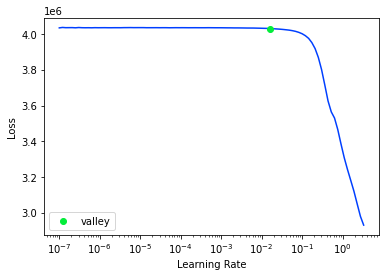

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    2005    2005.96
1    2002    2006.30
2    1993    2005.96
3    2006    2005.25
4    1993    2006.30
XGBoost RMSE:  8.505725


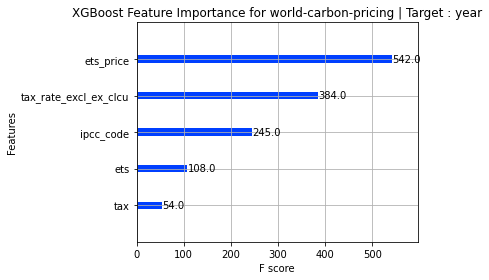

<Figure size 432x288 with 0 Axes>

In [22]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()


    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

                 feature  importance
0                    tax      158.00
1                    ets      225.00
2                   year     1209.00
3  tax_rate_excl_ex_clcu       92.00
4              ets_price      104.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

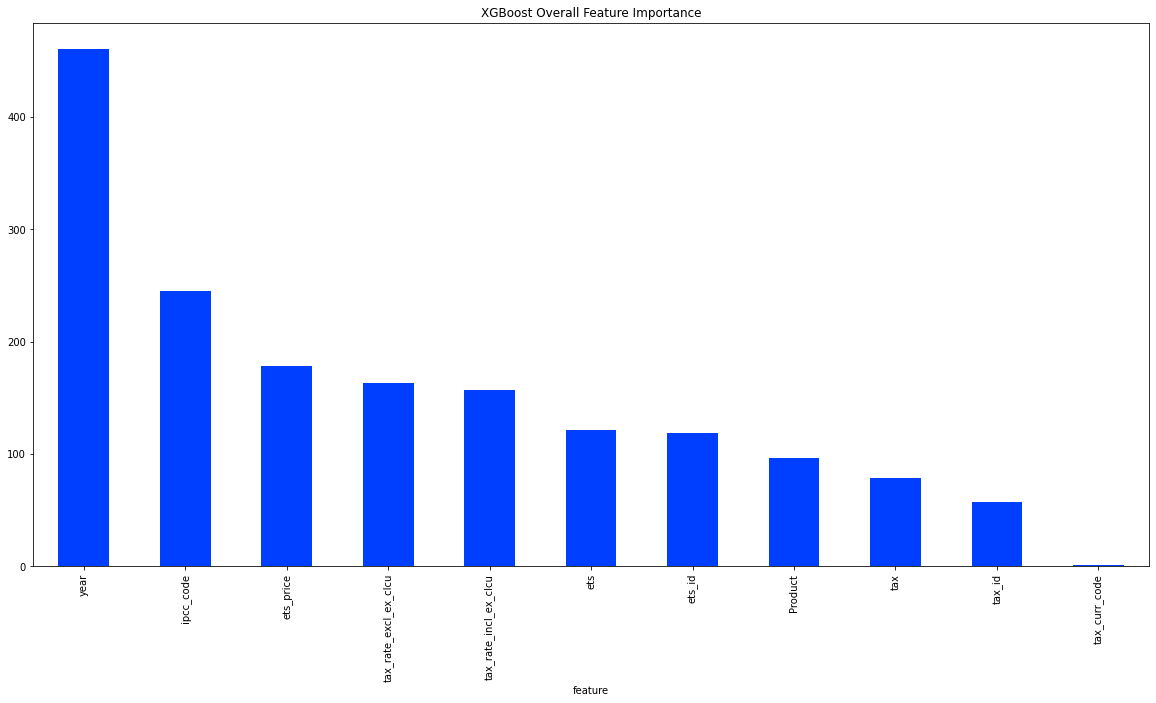

In [23]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [24]:
df.isna().sum()

jurisdiction             0
year                     0
ipcc_code                0
Product                  0
tax                      0
ets                      0
tax_id                   0
tax_rate_excl_ex_clcu    0
tax_ex_rate              0
tax_rate_incl_ex_clcu    0
tax_curr_code            0
ets_id                   0
ets_price                0
ets_curr_code            0
ets_2_id                 0
ets_2_price              0
ets_2_curr_code          0
dtype: int64

# **To Be Continued...**